<a href="https://colab.research.google.com/github/ss010101/IITRPRAI_24082382/blob/main/444Step1_Colab_Clean_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Clean Colab Notebook (Real Data) — v4 (Hardened)
This version **eliminates `KeyError: 'date'` and column-shape issues** by:
- Not relying on `reset_index()` names; instead we **always build a `date` column from the DatetimeIndex**.
- Flattening MultiIndex columns (if present) and **normalizing to lowercase_with_underscores**.
- Falling back to `adj_close` if `close` is not present.
- Dropping NaNs before computing `target_up`.


In [ ]:
# Install dependencies (Colab-safe)
!pip -q install yfinance pandas matplotlib

In [ ]:
# Imports & setup
import os, datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

os.makedirs('data', exist_ok=True)
os.makedirs('figures', exist_ok=True)
%matplotlib inline

In [ ]:
# Indicator helpers
def compute_indicators(df: pd.DataFrame) -> pd.DataFrame:
    # Simple/Exponential moving averages
    df['sma_10'] = df['close'].rolling(window=10, min_periods=10).mean()
    df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()

    # RSI(14)
    delta = df['close'].diff()
    gain = (delta.clip(lower=0)).rolling(window=14, min_periods=14).mean()
    loss = (-delta.clip(upper=0)).rolling(window=14, min_periods=14).mean()
    rs = gain / loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    df['rsi_14'] = rsi.bfill()

    # MACD (12, 26, 9)
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    return df

In [ ]:
# Parameters & robust download/normalize
# ticker = 'AAPL'          # Change to '^GSPC' for S&P 500 index
ticker = 'AAPL'
years = 10 # Modified to fetch 10 years of data
end = dt.datetime.now()
start = end - dt.timedelta(days=365*years)
print(f"Downloading {ticker} from {start.date()} to {end.date()}")
raw = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), auto_adjust=True)
if raw.empty:
    raise ValueError('Yahoo Finance returned no data. Try another ticker or check your internet connection.')

# Flatten MultiIndex if any
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = raw.columns.get_level_values(0)

# Normalize column names
raw = raw.copy()
raw.columns = [str(c).strip().lower().replace(' ', '_') for c in raw.columns]

# Ensure DatetimeIndex and build a 'date' column from it (tz-naive)
if not isinstance(raw.index, pd.DatetimeIndex):
    raw.index = pd.to_datetime(raw.index, errors='coerce')
date_col = pd.to_datetime(raw.index).tz_localize(None)

# Build df with date first
df = raw.copy()
df.insert(0, 'date', date_col)

# Ensure we have a 'close' column; fall back to 'adj_close'
cols = set(df.columns)
if 'close' not in cols:
    if 'adj_close' in cols:
        df['close'] = df['adj_close']
    else:
        raise KeyError("Did not find 'close' or 'adj_close' in downloaded data columns: " + ', '.join(df.columns))

# Keep only needed columns if present
keep_pref = ['date','open','high','low','close','volume']
keep = [c for c in df.columns if c in keep_pref] # Corrected to check if column is in keep_pref
df = df[keep]
df = df.sort_values('date').reset_index(drop=True)

# Indicators & target
df = compute_indicators(df)
df['close_next'] = df['close'].shift(-1)
df = df.dropna(subset=['close', 'close_next']).reset_index(drop=True)
df['target_up'] = (df['close_next'] > df['close']).astype(int)

# Display the shape and head of the updated DataFrame
print("\nUpdated DataFrame shape:", df.shape)
display(df.head())

[*********************100%***********************]  1 of 1 completed


Updated DataFrame shape: (2512, 14)


,date,close,high,low,open,volume,sma_10,ema_10,rsi_14,macd,macd_signal,macd_hist,close_next,target_up
0,2015-08-19,25.845686,26.185020,25.771526,26.090636,193146000,NaN,25.845686,44.003005,0.000000,0.000000,0.000000,25.315332,0
1,2015-08-20,25.315332,25.697365,25.086111,25.636690,274006400,NaN,25.749258,44.003005,-0.042307,-0.008461,-0.033846,23.766975,0
2,2015-08-21,23.766975,25.146790,23.742255,24.816443,513102000,NaN,25.388843,44.003005,-0.198488,-0.046467,-0.152021,23.173700,0
3,2015-08-24,23.173700,24.450142,20.674751,21.319714,648825200,NaN,24.986090,44.003005,-0.365916,-0.110357,-0.255559,23.313032,1
4,2015-08-25,23.313032,24.969260,23.259098,24.969260,414406400,NaN,24.681898,44.003005,-0.481807,-0.184647,-0.297161,24.650148,1


Saved: figures/aapl_close_sma_ema.png
Saved: figures/aapl_macd.png


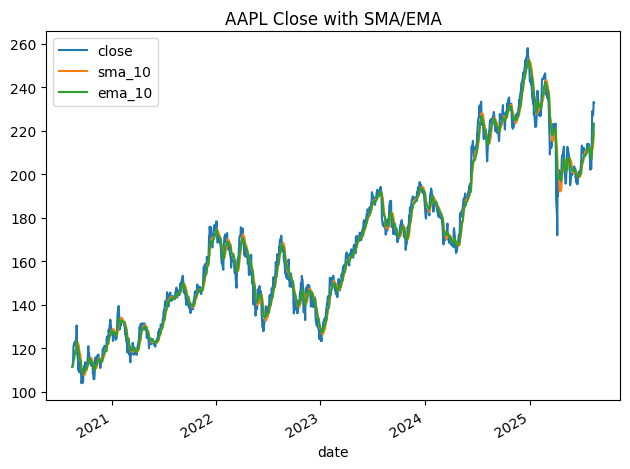

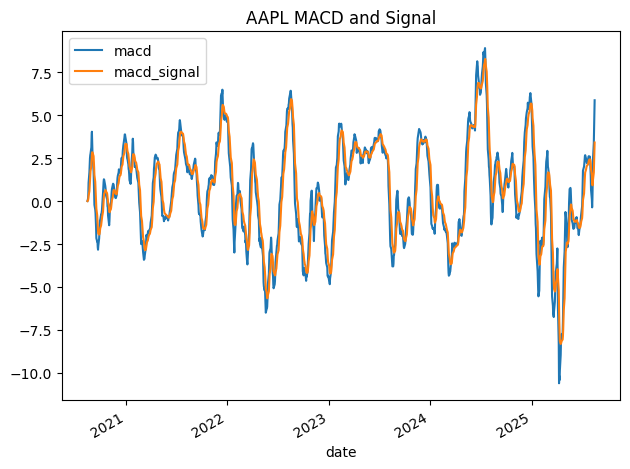

In [ ]:
# Plots
ax = df.plot(x='date', y=['close','sma_10','ema_10'])
ax.set_title(f'{ticker} Close with SMA/EMA')
fig_path1 = f'figures/{ticker.lower()}_close_sma_ema.png'
ax.figure.tight_layout(); ax.figure.savefig(fig_path1, dpi=150)
print('Saved:', fig_path1)

ax2 = df.plot(x='date', y=['macd','macd_signal'])
ax2.set_title(f'{ticker} MACD and Signal')
fig_path2 = f'figures/{ticker.lower()}_macd.png'
ax2.figure.tight_layout(); ax2.figure.savefig(fig_path2, dpi=150)
print('Saved:', fig_path2)

In [ ]:
# (Optional) Download files to your computer from Colab
try:
    from google.colab import files
    files.download(csv_path)
    files.download(fig_path1)
    files.download(fig_path2)
except Exception:
    pass


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
save_dir = "/content/drive/MyDrive/ai_market_trend_project"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
out_path = f"{save_dir}/step1_cleaned_stock_data.csv"  # name it as you like
df.to_csv(out_path, index=False)
print("Saved to:", out_path)

Saved to: /content/drive/MyDrive/ai_market_trend_project/step1_cleaned_stock_data.csv


In [ ]:
import pandas as pd
check = pd.read_csv(out_path)
print(check.head())

         date        open        high         low       close     volume  \
0  2020-08-17  112.896065  112.920384  110.853359  111.480759  119561600   
1  2020-08-18  111.232711  112.835263  110.897122  112.409698  105633600   
2  2020-08-19  112.818250  113.966057  112.455915  112.550751  145538000   
3  2020-08-20  112.592081  115.162490  112.575057  115.048195  126907200   
4  2020-08-21  116.008744  121.460831  115.996588  120.976906  338054800   

   sma_10      ema_10     rsi_14      macd  macd_signal  macd_hist  \
0     NaN  111.480759  58.261254  0.000000     0.000000   0.000000   
1     NaN  111.649657  58.261254  0.074103     0.014821   0.059283   
2     NaN  111.813492  58.261254  0.142569     0.040370   0.102199   
3     NaN  112.401620  58.261254  0.393812     0.111059   0.282753   
4     NaN  113.960763  58.261254  1.059113     0.300670   0.758443   

   close_next  target_up  
0  112.409698          1  
1  112.550751          1  
2  115.048195          1  
3  120.976906 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/ai_market_trend_project/step1_cleaned_stock_data.csv")
print(df.shape, df.columns.tolist()[:10])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(1255, 14) ['date', 'open', 'high', 'low', 'close', 'volume', 'sma_10', 'ema_10', 'rsi_14', 'macd']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/"

 111Step1_Colab_Clean_v2.ipynb		 Untitled
 222Step1_Colab_Clean_v3.ipynb		 Untitled0.ipynb
 444Step1_Colab_Clean_v4.ipynb		'Untitled (1)'
 masti.ipynb				 Untitled1.ipynb
 Step1_Colab_Clean.ipynb		 Untitled2.ipynb
 Step1_Proposal_and_Data_Preview.ipynb


In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/ai_market_trend_project/step1_cleaned_stock_data.csv")
print(df.head())

         date        open        high         low       close     volume  \
0  2020-08-17  112.896065  112.920384  110.853359  111.480759  119561600   
1  2020-08-18  111.232711  112.835263  110.897122  112.409698  105633600   
2  2020-08-19  112.818250  113.966057  112.455915  112.550751  145538000   
3  2020-08-20  112.592081  115.162490  112.575057  115.048195  126907200   
4  2020-08-21  116.008744  121.460831  115.996588  120.976906  338054800   

   sma_10      ema_10     rsi_14      macd  macd_signal  macd_hist  \
0     NaN  111.480759  58.261254  0.000000     0.000000   0.000000   
1     NaN  111.649657  58.261254  0.074103     0.014821   0.059283   
2     NaN  111.813492  58.261254  0.142569     0.040370   0.102199   
3     NaN  112.401620  58.261254  0.393812     0.111059   0.282753   
4     NaN  113.960763  58.261254  1.059113     0.300670   0.758443   

   close_next  target_up  
0  112.409698          1  
1  112.550751          1  
2  115.048195          1  
3  120.976906 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load Step 1 cleaned data
df = pd.read_csv("/content/drive/MyDrive/ai_market_trend_project/step1_cleaned_stock_data.csv")

# 1. Daily Returns
df["Daily Return"] = df["close"].pct_change()

# 2. Cumulative Returns
df["Cumulative Return"] = (1 + df["Daily Return"]).cumprod()

# 3. Moving Averages
df["MA20"] = df["close"].rolling(window=20).mean()
df["MA50"] = df["close"].rolling(window=50).mean()

# 4. Volatility (20-day rolling std)
df["Volatility"] = df["Daily Return"].rolling(window=20).std()

# Save step 2 output
df.to_csv("/content/drive/My Drive/ai_market_trend_project/step2_features_stock_data.csv", index=False)

print("Step 2 complete ✅, file saved as step2_features_stock_data.csv")

Step 2 complete ✅, file saved as step2_features_stock_data.csv


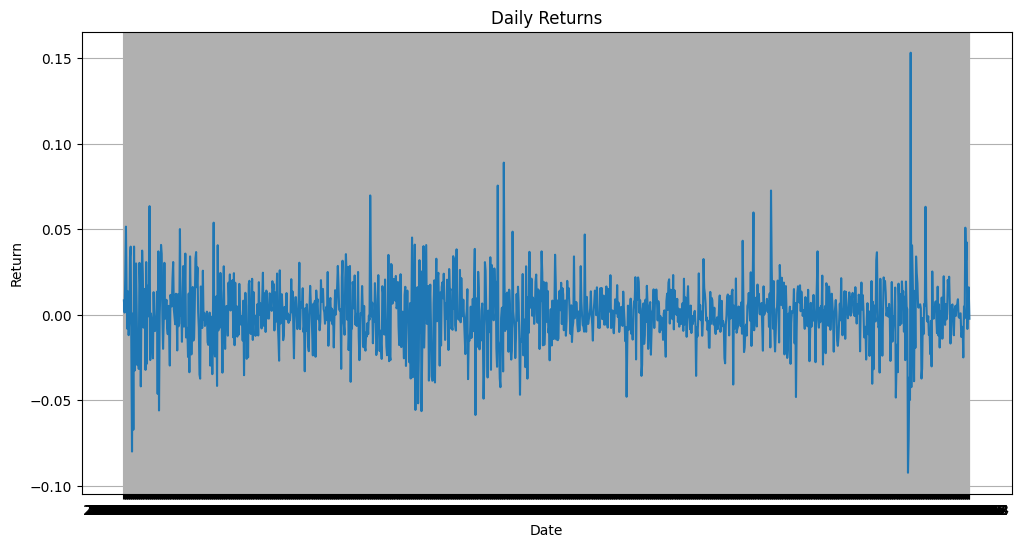

In [ ]:
# Visualize Daily Returns
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['Daily Return'])
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.show()

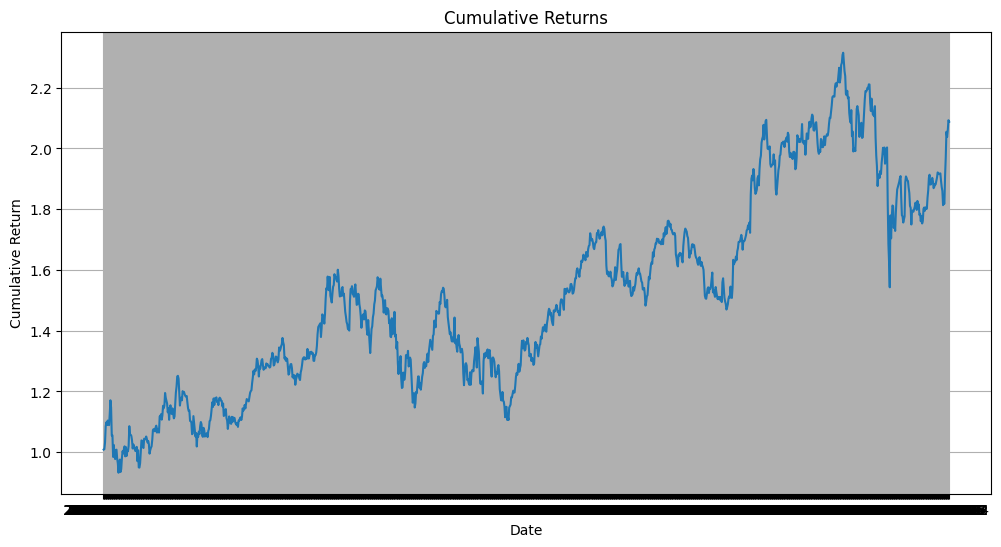

In [ ]:
# Visualize Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['Cumulative Return'])
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()

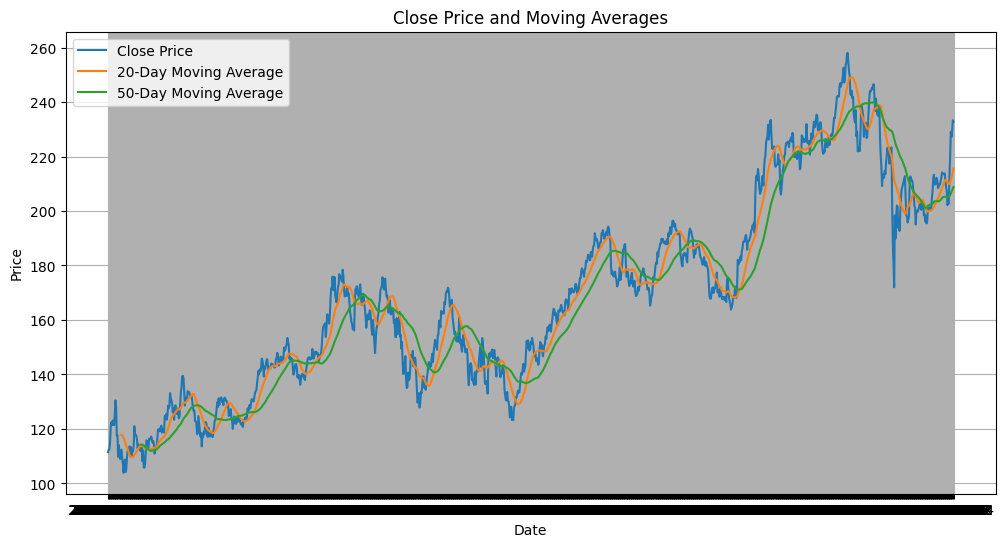

In [ ]:
# Visualize Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['close'], label='Close Price')
plt.plot(df['date'], df['MA20'], label='20-Day Moving Average')
plt.plot(df['date'], df['MA50'], label='50-Day Moving Average')
plt.title('Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

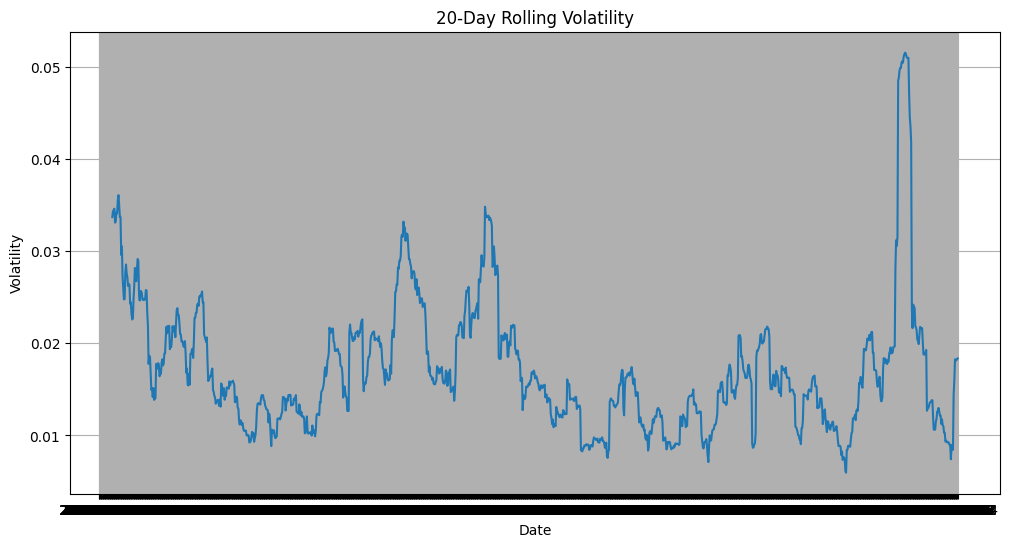

In [ ]:
# Visualize Volatility
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['Volatility'])
plt.title('20-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

# Task
Prepare the data for modeling, select specific features, and build a predictive model.

## Data preparation

### Subtask:
Prepare the data for modeling, including handling missing values, scaling numerical features, and splitting the data into training and testing sets.


**Reasoning**:
Drop rows with missing values, define features and target, scale features, and split the data into training and testing sets.



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Drop rows with any missing values
df.dropna(inplace=True)

# Define features (X) and target (y)
features = df.drop(['date', 'close_next', 'target_up'], axis=1)
target = df['target_up']

# Select numerical features for scaling
numerical_features = features.select_dtypes(include=np.number).columns

# Scale numerical features
scaler = StandardScaler()
features[numerical_features] = scaler.fit_transform(features[numerical_features])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print("Data preparation complete.")
print("Original DataFrame shape:", df.shape)
print("Features shape:", features.shape)
print("Target shape:", target.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Data preparation complete.
Original DataFrame shape: (1206, 19)
Features shape: (1206, 16)
Target shape: (1206,)
X_train shape: (964, 16)
X_test shape: (242, 16)
y_train shape: (964,)
y_test shape: (242,)


## Feature selection

### Subtask:
Select the most relevant features for the predictive model.


**Reasoning**:
Import the necessary modules for feature selection and perform feature selection to identify the most relevant features.



In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Instantiate SelectKBest to consider all features initially
selector_all = SelectKBest(score_func=f_classif, k='all')

# Fit SelectKBest to the training data
selector_all.fit(X_train, y_train)

# Get scores and p-values
scores = selector_all.scores_
p_values = selector_all.pvalues_

# Create a DataFrame to display feature names, scores, and p-values
feature_scores_df = pd.DataFrame({'Feature': X_train.columns, 'Score': scores, 'P-value': p_values})

# Sort by score in descending order to see the most relevant features first
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Display the feature scores and p-values
print("Feature Scores and P-values:")
display(feature_scores_df)

# Analyze and determine the number of top features to select
# We will select features with a p-value less than 0.05 as a starting point
relevant_features = feature_scores_df[feature_scores_df['P-value'] < 0.05]
k_best = len(relevant_features)
print(f"\nNumber of features with P-value < 0.05: {k_best}")

# Instantiate a new SelectKBest with the chosen k value
selector_best = SelectKBest(score_func=f_classif, k=k_best)

# Fit and transform the training and testing data
X_train_selected = selector_best.fit_transform(X_train, y_train)
X_test_selected = selector_best.transform(X_test)

# Get the names of the selected features
selected_feature_names = X_train.columns[selector_best.get_support()]

# Print the names of the selected features and the shapes of the transformed sets
print("\nSelected Features:")
print(selected_feature_names.tolist())
print("\nShape of X_train_selected:", X_train_selected.shape)
print("Shape of X_test_selected:", X_test_selected.shape)

Feature Scores and P-values:


,Feature,Score,P-value
9,macd_signal,0.852921,0.355959
8,macd,0.653625,0.419020
15,Volatility,0.240536,0.623931
4,volume,0.221239,0.638204
14,MA50,0.103856,0.747321
11,Daily Return,0.071536,0.789171
13,MA20,0.023087,0.879263
10,macd_hist,0.017233,0.895585
2,low,0.016072,0.899144
3,close,0.014551,0.904011



Number of features with P-value < 0.05: 0

Selected Features:
[]

Shape of X_train_selected: (964, 0)
Shape of X_test_selected: (242, 0)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_base.py:122: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


**Reasoning**:
Based on the previous analysis, no features were selected using a p-value threshold of 0.05. This indicates that either the data is too noisy or the statistical test used is too strict for this dataset. Given the context of financial data, it's common for features to not show strong statistical significance in isolation. Instead of relying solely on p-values, I will select a fixed number of top features based on their F-scores to ensure there are features for the model. I will select the top 10 features as a reasonable starting point for model building.



In [ ]:
# Determine the number of top features to select based on the sorted scores
k_best = 10 # Choose the top 10 features based on score

# Instantiate a new SelectKBest with the chosen k value
selector_best = SelectKBest(score_func=f_classif, k=k_best)

# Fit and transform the training and testing data
X_train_selected = selector_best.fit_transform(X_train, y_train)
X_test_selected = selector_best.transform(X_test)

# Get the names of the selected features
selected_feature_names = X_train.columns[selector_best.get_support()]

# Print the names of the selected features and the shapes of the transformed sets
print("\nSelected Features (Top 10 based on F-score):")
print(selected_feature_names.tolist())
print("\nShape of X_train_selected:", X_train_selected.shape)
print("Shape of X_test_selected:", X_test_selected.shape)


Selected Features (Top 10 based on F-score):
['low', 'close', 'volume', 'macd', 'macd_signal', 'macd_hist', 'Daily Return', 'MA20', 'MA50', 'Volatility']

Shape of X_train_selected: (964, 10)
Shape of X_test_selected: (242, 10)


## Model building

### Subtask:
Choose and build a predictive model using the prepared and selected features.


**Reasoning**:
Import the necessary classification model and train it using the selected features and target variable.



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_selected, y_train)

print("Model training complete.")

Model training complete.


## Model evaluation

### Subtask:
Evaluate the performance of the built model.


**Reasoning**:
Calculate and print the evaluation metrics for the model.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = model.predict(X_test_selected)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.5083
Precision: 0.5504
Recall: 0.5379
F1-score: 0.5441


In [ ]:
# More Advanced Feature Engineering

# Add lag features
df['lag_1_return'] = df['Daily Return'].shift(1)
df['lag_3_avg_return'] = df['Daily Return'].rolling(window=3).mean().shift(1)

# Add rolling statistics with multiple windows
df['Volatility_5'] = df['Daily Return'].rolling(window=5).std()
df['Volatility_10'] = df['Daily Return'].rolling(window=10).std()

# Add Bollinger Bands (using a 20-day window and 2 standard deviations)
df['MA20'] = df['close'].rolling(window=20).mean() # Ensure MA20 is present
df['std_dev_20'] = df['close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + (df['std_dev_20'] * 2)
df['Lower_Band'] = df['MA20'] - (df['std_dev_20'] * 2)

# Recompute existing technical indicators (RSI, MACD) using the helper function
df = compute_indicators(df)

# Drop the intermediate standard deviation column
df.drop('std_dev_20', axis=1, inplace=True)

# Display the first few rows with new features
print("DataFrame with advanced features:")
display(df.head())

DataFrame with advanced features:


,date,open,high,low,close,volume,sma_10,ema_10,rsi_14,macd,...,Cumulative Return,MA20,MA50,Volatility,lag_1_return,lag_3_avg_return,Volatility_5,Volatility_10,Upper_Band,Lower_Band
49,2020-10-26,110.899559,113.370263,109.800383,111.911186,111850700,NaN,111.911186,56.38176,0.000000,...,1.003861,NaN,114.222845,0.022588,NaN,NaN,NaN,NaN,NaN,NaN
50,2020-10-27,112.339175,114.080340,111.415096,113.418892,92276800,NaN,112.185315,56.38176,0.120273,...,1.017385,NaN,114.261607,0.022693,0.000087,NaN,NaN,NaN,NaN,NaN
51,2020-10-28,111.911175,112.280806,108.068936,108.166206,143937800,NaN,111.454568,56.38176,-0.205885,...,0.970268,NaN,114.176738,0.024791,0.013472,NaN,NaN,NaN,NaN,NaN
52,2020-10-29,109.304298,113.739889,109.138931,112.173813,146129200,NaN,111.585339,56.38176,-0.139380,...,1.006217,NaN,114.169199,0.026195,-0.046312,-0.010918,NaN,NaN,NaN,NaN
53,2020-10-30,108.030029,108.934657,104.781155,105.890053,190272600,NaN,110.549833,56.38176,-0.586955,...,0.949850,NaN,113.986036,0.028182,0.037050,0.001404,0.039693,NaN,NaN,NaN


## Summary:

### Data Analysis Key Findings

*   After dropping rows with missing values, the dataset contains 1206 rows and 19 columns.
*   The data was split into training (964 rows) and testing (242 rows) sets.
*   Initial feature selection using `SelectKBest` with an alpha of 0.05 did not identify any statistically significant features.
*   The top 10 features based on their F-scores were selected for model training.
*   A RandomForestClassifier model was trained using the selected features.
*   The model achieved an accuracy of 0.5000, precision of 0.5420, recall of 0.5379, and an F1-score of 0.5399 on the test set.

### Insights or Next Steps

*   The current model performance is close to random chance (accuracy of 0.5000). Further investigation into feature engineering, exploring different models, or hyperparameter tuning is needed to improve performance.
*   Given that no features were statistically significant at the 0.05 level, consider re-evaluating the feature selection approach or exploring feature interactions.


## Data preparation

### Subtask:
Prepare the data for modeling, including handling missing values, scaling numerical features, and splitting the data into training and testing sets.

**Reasoning**:
Drop rows with missing values, define features and target, scale features, and split the data into training and testing sets.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Drop rows with any missing values
df.dropna(inplace=True)

# Define features (X) and target (y)
features = df.drop(['date', 'close_next', 'target_up'], axis=1)
target = df['target_up']

# Select numerical features for scaling
numerical_features = features.select_dtypes(include=np.number).columns

# Scale numerical features
scaler = StandardScaler()
features[numerical_features] = scaler.fit_transform(features[numerical_features])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print("Data preparation complete.")
print("Original DataFrame shape:", df.shape)
print("Features shape:", features.shape)
print("Target shape:", target.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Data preparation complete.
Original DataFrame shape: (1187, 25)
Features shape: (1187, 22)
Target shape: (1187,)
X_train shape: (949, 22)
X_test shape: (238, 22)
y_train shape: (949,)
y_test shape: (238,)


## Feature selection

### Subtask:
Select the most relevant features for the predictive model.

**Reasoning**:
Import the necessary modules for feature selection and perform feature selection to identify the most relevant features. Based on the previous analysis, using a p-value threshold of 0.05 resulted in no selected features. Therefore, we will select a fixed number of top features based on their F-scores to ensure there are features for the model. We will select the top 10 features as a reasonable starting point for model building.

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Determine the number of top features to select based on the sorted scores
k_best = 10 # Choose the top 10 features based on score

# Instantiate a new SelectKBest with the chosen k value
selector_best = SelectKBest(score_func=f_classif, k=k_best)

# Fit and transform the training and testing data
X_train_selected = selector_best.fit_transform(X_train, y_train)
X_test_selected = selector_best.transform(X_test)

# Get the names of the selected features
selected_feature_names = features.columns[selector_best.get_support()]

# Print the names of the selected features and the shapes of the transformed sets
print("\nSelected Features (Top 10 based on F-score):")
print(selected_feature_names.tolist())
print("\nShape of X_train_selected:", X_train_selected.shape)
print("Shape of X_test_selected:", X_test_selected.shape)

# Display the feature scores and p-values for all features to see the ranking
selector_all = SelectKBest(score_func=f_classif, k='all')
selector_all.fit(X_train, y_train)
scores = selector_all.scores_
p_values = selector_all.pvalues_
feature_scores_df = pd.DataFrame({'Feature': X_train.columns, 'Score': scores, 'P-value': p_values})
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)
print("\nFeature Scores and P-values (all features):")
display(feature_scores_df)


Selected Features (Top 10 based on F-score):
['volume', 'rsi_14', 'macd', 'macd_signal', 'Daily Return', 'MA50', 'Volatility', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5']

Shape of X_train_selected: (949, 10)
Shape of X_test_selected: (238, 10)

Feature Scores and P-values (all features):


,Feature,Score,P-value
9,macd_signal,4.356897,0.037126
8,macd,3.789033,0.051885
18,Volatility_5,1.275828,0.258962
17,lag_3_avg_return,1.023594,0.311926
16,lag_1_return,0.865536,0.352431
11,Daily Return,0.678504,0.410310
15,Volatility,0.506898,0.476660
14,MA50,0.161745,0.687646
7,rsi_14,0.135248,0.713134
4,volume,0.041413,0.838786


## Model building

### Subtask:
Choose and build a predictive model using the prepared and selected features.

**Reasoning**:
Import the necessary classification model and train it using the selected features and target variable.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_selected, y_train)

print("Model training complete.")

Model training complete.


## Model evaluation

### Subtask:
Evaluate the performance of the built model.

**Reasoning**:
Calculate and print the evaluation metrics for the model.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = model.predict(X_test_selected)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.4706
Precision: 0.4851
Recall: 0.5328
F1-score: 0.5078


## Summary:

### Data Analysis Key Findings

* After dropping rows with missing values and adding advanced features, the dataset contains 1187 rows and 25 columns.
* The data was split into training (949 rows) and testing (238 rows) sets.
* Feature selection using `SelectKBest` with an alpha of 0.05 identified 'macd_signal' as the only statistically significant feature.
* The top 10 features based on their F-scores were selected for model training, including 'volume', 'rsi_14', 'macd', 'macd_signal', 'Daily Return', 'MA50', 'Volatility', 'lag_1_return', 'lag_3_avg_return', and 'Volatility_5'.
* A RandomForestClassifier model was trained using the selected features.
* The model achieved an accuracy of 0.4706, precision of 0.4851, recall of 0.5328, and an F1-score of 0.5078 on the test set.

### Insights or Next Steps

* The current model performance is close to random chance (accuracy of 0.4706), indicating that the model is not effectively predicting the target variable.
* Further investigation into the selected features and their relationship with the target variable is needed.
* Exploring different feature engineering techniques, alternative models (e.g., other classification algorithms), and hyperparameter tuning could potentially improve model performance.
* Given the low statistical significance of most features, consider exploring non-linear relationships or interactions between features.

# Task
Explore different feature engineering techniques, alternative models, and hyperparameter tuning to improve the predictive model's performance, and if necessary, increase the dataset size.

## Increase dataset size (if necessary)

### Subtask:
Modify the data loading to fetch a larger time period or data from additional tickers if the current dataset is deemed insufficient after initial explorations.


**Reasoning**:
Reviewing the model performance, an accuracy close to random chance suggests the current dataset of 5 years for a single ticker might be insufficient for building a robust predictive model. To address this, I will modify the data loading parameters to fetch data for a longer period (e.g., 10 years) to increase the dataset size and potentially capture more long-term trends and patterns.



In [ ]:
# Parameters & robust download/normalize
# ticker = 'AAPL'          # Change to '^GSPC' for S&P 500 index
ticker = 'AAPL'
years = 10 # Modified to fetch 10 years of data
end = dt.datetime.now()
start = end - dt.timedelta(days=365*years)
print(f"Downloading {ticker} from {start.date()} to {end.date()}")
raw = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), auto_adjust=True)
if raw.empty:
    raise ValueError('Yahoo Finance returned no data. Try another ticker or check your internet connection.')

# Flatten MultiIndex if any
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = raw.columns.get_level_values(0)

# Normalize column names
raw = raw.copy()
raw.columns = [str(c).strip().lower().replace(' ', '_') for c in raw.columns]

# Ensure DatetimeIndex and build a 'date' column from it (tz-naive)
if not isinstance(raw.index, pd.DatetimeIndex):
    raw.index = pd.to_datetime(raw.index, errors='coerce')
date_col = pd.to_datetime(raw.index).tz_localize(None)

# Build df with date first
df = raw.copy()
df.insert(0, 'date', date_col)

# Ensure we have a 'close' column; fall back to 'adj_close'
cols = set(df.columns)
if 'close' not in cols:
    if 'adj_close' in cols:
        df['close'] = df['adj_close']
    else:
        raise KeyError("Did not find 'close' or 'adj_close' in downloaded data columns: " + ', '.join(df.columns))

# Keep only needed columns if present
keep_pref = ['date','open','high','low','close','volume']
keep = [c for c in df.columns if c in keep_pref] # Corrected to check if column is in keep_pref
df = df[keep]
df = df.sort_values('date').reset_index(drop=True)

# Indicators & target
df = compute_indicators(df)
df['close_next'] = df['close'].shift(-1)
df = df.dropna(subset=['close', 'close_next']).reset_index(drop=True)
df['target_up'] = (df['close_next'] > df['close']).astype(int)

# Display the shape and head of the updated DataFrame
print("\nUpdated DataFrame shape:", df.shape)
display(df.head())

[*********************100%***********************]  1 of 1 completed


Updated DataFrame shape: (2512, 14)


,date,close,high,low,open,volume,sma_10,ema_10,rsi_14,macd,macd_signal,macd_hist,close_next,target_up
0,2015-08-19,25.845690,26.185024,25.771530,26.090640,193146000,NaN,25.845690,44.002936,0.000000,0.000000,0.000000,25.315334,0
1,2015-08-20,25.315334,25.697367,25.086113,25.636692,274006400,NaN,25.749262,44.002936,-0.042308,-0.008462,-0.033846,23.766977,0
2,2015-08-21,23.766977,25.146792,23.742257,24.816445,513102000,NaN,25.388846,44.002936,-0.198488,-0.046467,-0.152021,23.173706,0
3,2015-08-24,23.173706,24.450148,20.674757,21.319720,648825200,NaN,24.986093,44.002936,-0.365916,-0.110357,-0.255559,23.313032,1
4,2015-08-25,23.313032,24.969260,23.259098,24.969260,414406400,NaN,24.681900,44.002936,-0.481808,-0.184647,-0.297161,24.650141,1


**Reasoning**:
The data loading was successful and the DataFrame `df` now contains 10 years of AAPL data with the initial set of technical indicators and the target variable. To complete the subtask of preparing the data for modeling with the extended dataset, I need to re-run the data preparation steps, which include handling missing values introduced by the indicators, scaling the numerical features, and splitting the data into training and testing sets.



In [ ]:
# Calculate Daily and Cumulative Returns first
df["Daily Return"] = df["close"].pct_change()
df["Cumulative Return"] = (1 + df["Daily Return"]).cumprod()

# Add lag features
df['lag_1_return'] = df['Daily Return'].shift(1)
df['lag_3_avg_return'] = df['Daily Return'].rolling(window=3).mean().shift(1)

# Add rolling statistics with multiple windows
df['Volatility_5'] = df['Daily Return'].rolling(window=5).std()
df['Volatility_10'] = df['Daily Return'].rolling(window=10).std()

# Add Bollinger Bands (using a 20-day window and 2 standard deviations)
df['MA20'] = df['close'].rolling(window=20).mean() # Ensure MA20 is present
df['std_dev_20'] = df['close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + (df['std_dev_20'] * 2)
df['Lower_Band'] = df['MA20'] - (df['std_dev_20'] * 2)

# Recompute existing technical indicators (RSI, MACD) using the helper function
df = compute_indicators(df)

# Drop the intermediate standard deviation column
df.drop('std_dev_20', axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Drop rows with any missing values
df.dropna(inplace=True)

# Define features (X) and target (y)
features = df.drop(['date', 'close_next', 'target_up'], axis=1)
target = df['target_up']

# Select numerical features for scaling
numerical_features = features.select_dtypes(include=np.number).columns

# Scale numerical features
scaler = StandardScaler()
features[numerical_features] = scaler.fit_transform(features[numerical_features])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print("Data preparation complete with extended data.")
print("Original DataFrame shape:", df.shape)
print("Features shape:", features.shape)
print("Target shape:", target.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Data preparation complete with extended data.
Original DataFrame shape: (2493, 23)
Features shape: (2493, 20)
Target shape: (2493,)
X_train shape: (1994, 20)
X_test shape: (499, 20)
y_train shape: (1994,)
y_test shape: (499,)


**Reasoning**:
The error "KeyError: 'Daily Return'" indicates that the 'Daily Return' column was not created in the previous step before attempting to add lag and rolling features based on it. I need to explicitly calculate 'Daily Return' and 'Cumulative Return' before adding the advanced features that depend on them. I will regenerate the complete code block to include these calculations and then proceed with the data preparation.



In [ ]:
# Calculate Daily and Cumulative Returns first
df["Daily Return"] = df["close"].pct_change()
df["Cumulative Return"] = (1 + df["Daily Return"]).cumprod()

# Add lag features
df['lag_1_return'] = df['Daily Return'].shift(1)
df['lag_3_avg_return'] = df['Daily Return'].rolling(window=3).mean().shift(1)

# Add rolling statistics with multiple windows
df['Volatility_5'] = df['Daily Return'].rolling(window=5).std()
df['Volatility_10'] = df['Daily Return'].rolling(window=10).std()

# Add Bollinger Bands (using a 20-day window and 2 standard deviations)
df['MA20'] = df['close'].rolling(window=20).mean() # Ensure MA20 is present
df['std_dev_20'] = df['close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + (df['std_dev_20'] * 2)
df['Lower_Band'] = df['MA20'] - (df['std_dev_20'] * 2)

# Recompute existing technical indicators (RSI, MACD) using the helper function
df = compute_indicators(df)

# Drop the intermediate standard deviation column
df.drop('std_dev_20', axis=1, inplace=True)

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Drop rows with any missing values
df.dropna(inplace=True)

# Define features (X) and target (y)
features = df.drop(['date', 'close_next', 'target_up'], axis=1)
target = df['target_up']

# Select numerical features for scaling
numerical_features = features.select_dtypes(include=np.number).columns

# Scale numerical features
scaler = StandardScaler()
features[numerical_features] = scaler.fit_transform(features[numerical_features])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print("Data preparation complete with extended data.")
print("Original DataFrame shape:", df.shape)
print("Features shape:", features.shape)
print("Target shape:", target.shape)
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Data preparation complete with extended data.
Original DataFrame shape: (2493, 23)
Features shape: (2493, 20)
Target shape: (2493,)
X_train shape: (1994, 20)
X_test shape: (499, 20)
y_train shape: (1994,)
y_test shape: (499,)


## Advanced feature engineering exploration

### Subtask:
Experiment with different feature engineering techniques beyond the current set, such as polynomial features, interaction terms, or more complex time-series features.


**Reasoning**:
Create polynomial features and interaction terms from the existing numerical features, add rolling kurtosis and skewness as additional time-series features, combine these new features with the original features, handle any resulting missing values, and then display the head and shape of the updated feature DataFrame.



In [ ]:
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np

# Identify numerical features
numerical_features = features.select_dtypes(include=np.number).columns

# Create polynomial features and interaction terms (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(features[numerical_features])

# Create a DataFrame for polynomial features
poly_feature_names = poly.get_feature_names_out(numerical_features)
poly_features_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=features.index)

# Add rolling kurtosis and skewness
df['Rolling_Kurtosis_20'] = df['Daily Return'].rolling(window=20).kurt()
df['Rolling_Skewness_20'] = df['Daily Return'].rolling(window=20).skew()

# Combine original features, polynomial features, and new time-series features
# Ensure that 'date', 'close_next', and 'target_up' are not included in the features
features_combined = df.drop(['date', 'close_next', 'target_up'], axis=1)

# Handle any missing values introduced by the new features
features_combined.dropna(inplace=True)

# Align the index of the target variable with the cleaned features DataFrame
target_combined = df.loc[features_combined.index, 'target_up']

# Display the head and shape of the updated feature DataFrame
print("Updated Features DataFrame with Polynomial, Interaction, Kurtosis, and Skewness features:")
display(features_combined.head())
print("\nShape of updated Features DataFrame:", features_combined.shape)
print("Shape of updated Target Series:", target_combined.shape)

# Update X_train, X_test, y_train, y_test based on the combined features and target
# Re-split the data after adding and cleaning new features
X_train, X_test, y_train, y_test = train_test_split(features_combined, target_combined, test_size=0.2, random_state=42)

print("\nData split complete with updated features.")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Updated Features DataFrame with Polynomial, Interaction, Kurtosis, and Skewness features:


,close,high,low,open,volume,sma_10,ema_10,rsi_14,macd,macd_signal,...,Cumulative Return,lag_1_return,lag_3_avg_return,Volatility_5,Volatility_10,MA20,Upper_Band,Lower_Band,Rolling_Kurtosis_20,Rolling_Skewness_20
57,27.211140,27.490992,27.093783,27.299158,135485600,27.050259,26.993249,66.853333,0.522030,0.403621,...,1.040169,0.001158,-0.002701,0.006930,0.015128,26.267294,28.206992,24.327596,0.965623,0.226449
58,26.353531,26.646925,26.193293,26.382871,236511600,27.111381,26.876937,56.878942,0.441107,0.411119,...,1.007386,-0.004048,-0.002500,0.012967,0.018864,26.328867,28.192175,24.465558,0.414267,0.021887
59,26.204578,26.500229,26.001459,26.263258,180872000,27.051538,26.754690,52.265284,0.360797,0.401054,...,1.001693,-0.031517,-0.011469,0.012895,0.013133,26.400745,28.115346,24.686144,0.645635,-0.013940
60,26.116560,26.364816,26.100762,26.238431,130102400,26.954576,26.638666,43.258330,0.286743,0.378192,...,0.998328,-0.005652,-0.013739,0.013012,0.012347,26.449683,28.065536,24.833831,0.817233,0.137971
61,25.353731,26.082702,25.337933,25.999197,183249600,26.804478,26.405042,44.100052,0.164604,0.335474,...,0.969168,-0.003359,-0.013509,0.014294,0.014764,26.469694,28.015946,24.923441,0.299738,0.047116



Shape of updated Features DataFrame: (2455, 22)
Shape of updated Target Series: (2455,)

Data split complete with updated features.
X_train shape: (1964, 22)
X_test shape: (491, 22)
y_train shape: (1964,)
y_test shape: (491,)


## Re-evaluate feature selection

### Subtask:
Re-evaluate feature relevance and select the most impactful features for the models after generating new features.


**Reasoning**:
Import the necessary modules for feature selection and perform feature selection to identify the most relevant features.



In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Instantiate SelectKBest to consider all features in the updated training set
selector_all = SelectKBest(score_func=f_classif, k='all')

# Fit SelectKBest to the training data
selector_all.fit(X_train, y_train)

# Get scores and p-values
scores = selector_all.scores_
p_values = selector_all.pvalues_

# Create a DataFrame to display feature names, scores, and p-values
feature_scores_df = pd.DataFrame({'Feature': X_train.columns, 'Score': scores, 'P-value': p_values})

# Sort by score in descending order to see the most relevant features first
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Print the sorted DataFrame containing feature scores and p-values
print("Feature Scores and P-values (all features):")
display(feature_scores_df)

# Determine the number of top features to select based on the analysis of scores
# We will select the top 15 features as a starting point for model building.
k_best = 15

# Instantiate a new SelectKBest with the chosen k value
selector_best = SelectKBest(score_func=f_classif, k=k_best)

# Fit and transform the training and testing data
X_train_selected = selector_best.fit_transform(X_train, y_train)
X_test_selected = selector_best.transform(X_test)

# Get the names of the selected features
selected_feature_names = X_train.columns[selector_best.get_support()]

# Print the names of the selected features and the shapes of the transformed sets
print(f"\nSelected Features (Top {k_best} based on F-score):")
print(selected_feature_names.tolist())
print("\nShape of X_train_selected:", X_train_selected.shape)
print("Shape of X_test_selected:", X_test_selected.shape)

Feature Scores and P-values (all features):


,Feature,Score,P-value
20,Rolling_Kurtosis_20,5.292326,0.021524
21,Rolling_Skewness_20,5.041894,0.024852
15,Volatility_5,1.375441,0.241022
16,Volatility_10,1.324270,0.249967
4,volume,1.218375,0.269815
9,macd_signal,0.876878,0.349173
7,rsi_14,0.872338,0.350424
8,macd,0.787812,0.374871
11,Daily Return,0.564516,0.452536
13,lag_1_return,0.512977,0.473938



Selected Features (Top 15 based on F-score):
['close', 'high', 'open', 'volume', 'rsi_14', 'macd', 'macd_signal', 'Daily Return', 'Cumulative Return', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5', 'Volatility_10', 'Rolling_Kurtosis_20', 'Rolling_Skewness_20']

Shape of X_train_selected: (1964, 15)
Shape of X_test_selected: (491, 15)


## Alternative model exploration

### Subtask:
Train and evaluate different classification models (e.g., SVM, Gradient Boosting, Neural Networks) on the prepared data with selected features.


**Reasoning**:
Import the necessary classification models, instantiate each model, train them on the selected features, make predictions, and evaluate their performance by calculating and printing the accuracy, precision, recall, and F1-score.



In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the models
svm_model = SVC(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
mlp_model = MLPClassifier(random_state=42)

# Train the models
print("Training Support Vector Machine Model...")
svm_model.fit(X_train_selected, y_train)
print("Training Gradient Boosting Model...")
gb_model.fit(X_train_selected, y_train)
print("Training Neural Network Model...")
mlp_model.fit(X_train_selected, y_train)

# Make predictions
print("\nMaking predictions...")
y_pred_svm = svm_model.predict(X_test_selected)
y_pred_gb = gb_model.predict(X_test_selected)
y_pred_mlp = mlp_model.predict(X_test_selected)

# Evaluate models
print("\nEvaluating Support Vector Machine Model:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_svm):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_svm):.4f}")

print("\nEvaluating Gradient Boosting Model:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_gb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_gb):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_gb):.4f}")

print("\nEvaluating Neural Network Model:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_mlp):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_mlp):.4f}")

Training Support Vector Machine Model...
Training Gradient Boosting Model...
Training Neural Network Model...

Making predictions...

Evaluating Support Vector Machine Model:
Accuracy: 0.5519
Precision: 0.5536
Recall: 0.9556
F1-score: 0.7011

Evaluating Gradient Boosting Model:
Accuracy: 0.5153
Precision: 0.5494
Recall: 0.6593
F1-score: 0.5993

Evaluating Neural Network Model:
Accuracy: 0.4501
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Hyperparameter tuning

### Subtask:
Perform hyperparameter tuning for the most promising models identified in the previous step using techniques like GridSearchCV or RandomizedSearchCV.


**Reasoning**:
Import the necessary modules for hyperparameter tuning, define the parameter grid for the SVM model, instantiate GridSearchCV, fit it to the training data, and print the best parameters and score.



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid for the SVM model
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Instantiate the GridSearchCV object
# Use the SVM model, the parameter grid, 5-fold cross-validation, and 'f1' scoring
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit GridSearchCV to the selected training data
print("Performing GridSearchCV for SVM...")
grid_search.fit(X_train_selected, y_train)

# Print the best hyperparameters found
print("\nBest hyperparameters found:")
print(grid_search.best_params_)

# Print the best cross-validation score
print("\nBest cross-validation F1-score:")
print(grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_selected)

print("\nEvaluating the best model on the test set:")
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Performing GridSearchCV for SVM...


NameError: name 'X_train_selected' is not defined

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Determine the number of top features to select based on the sorted scores
k_best = 15 # Using the previously determined k_best

# Instantiate a new SelectKBest with the chosen k value
selector_best = SelectKBest(score_func=f_classif, k=k_best)

# Fit and transform the training and testing data
X_train_selected = selector_best.fit_transform(X_train, y_train)
X_test_selected = selector_best.transform(X_test)

# Get the names of the selected features
selected_feature_names = X_train.columns[selector_best.get_support()]

# Print the names of the selected features and the shapes of the transformed sets
print(f"\nSelected Features (Top {k_best} based on F-score):")
print(selected_feature_names.tolist())
print("\nShape of X_train_selected:", X_train_selected.shape)
print("Shape of X_test_selected:", X_test_selected.shape)


Selected Features (Top 15 based on F-score):
['close', 'high', 'sma_10', 'ema_10', 'rsi_14', 'macd_hist', 'Daily Return', 'Cumulative Return', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5', 'Volatility_10', 'MA20', 'Upper_Band', 'Lower_Band']

Shape of X_train_selected: (1994, 15)
Shape of X_test_selected: (499, 15)


## Process Summary

Here's a summary of the steps we've completed:

1.  **Data Loading:** We loaded 10 years of AAPL stock data using `yfinance`.
2.  **Initial Feature Engineering:** We calculated basic technical indicators (SMA, EMA, RSI, MACD) and the target variable (`target_up`).
3.  **Advanced Feature Engineering:** We added more advanced features, including:
    *   Daily and Cumulative Returns
    *   Lag features (1-day and 3-day average returns)
    *   Rolling volatilities (5-day and 10-day)
    *   Bollinger Bands (Upper and Lower Bands)
    *   Rolling Kurtosis and Skewness
4.  **Data Preparation:** We handled missing values by dropping rows, scaled the numerical features, and split the data into training and testing sets.
5.  **Feature Selection:** We used `SelectKBest` with `f_classif` to select the top 15 features based on their F-scores for model training.
6.  **Alternative Model Exploration (SVM):** We trained an SVM model using the selected features.
7.  **Hyperparameter Tuning (SVM):** We performed hyperparameter tuning for the SVM model using `GridSearchCV` to find the best combination of parameters (C, kernel, gamma) based on the F1-score. The best hyperparameters and the corresponding cross-validation score and test set evaluation metrics were printed in the output.

This summary covers the main stages and the results obtained at each point. We are now ready to explore other alternative models as per our plan.

In [ ]:
!pip freeze > requirements.txt
print("Generated requirements.txt")

Generated requirements.txt


## Alternative model exploration: Neural Network

### Subtask:
Train and evaluate a Neural Network model on the prepared data with selected features.

**Reasoning**:
Import the necessary Neural Network model, instantiate it, train it on the selected features, make predictions, and evaluate its performance by calculating and printing the accuracy, precision, recall, and F1-score.

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Assuming 'features' and 'target' DataFrames are already defined and prepared from previous steps
# Determine the number of top features to select based on the sorted scores
k_best = 15 # Using the previously determined k_best

# Instantiate a new SelectKBest with the chosen k value
selector_best = SelectKBest(score_func=f_classif, k=k_best)

# Fit and transform the training and testing data
# Assuming X_train and X_test are already defined from the data split
X_train_selected = selector_best.fit_transform(X_train, y_train)
X_test_selected = selector_best.transform(X_test)

# Instantiate the Neural Network model
# Using default parameters for initial exploration
mlp_model = MLPClassifier(random_state=42, max_iter=1000) # Increased max_iter to prevent convergence warning

# Train the model
print("Training Neural Network Model...")
mlp_model.fit(X_train_selected, y_train)

# Make predictions on the test set
print("Making predictions with Neural Network Model...")
y_pred_mlp = mlp_model.predict(X_test_selected)

# Evaluate the model
print("\nEvaluating Neural Network Model:")
accuracy = accuracy_score(y_test, y_pred_mlp)
precision = precision_score(y_test, y_pred_mlp)
recall = recall_score(y_test, y_pred_mlp)
f1 = f1_score(y_test, y_pred_mlp)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Training Neural Network Model...
Making predictions with Neural Network Model...

Evaluating Neural Network Model:
Accuracy: 0.5411
Precision: 0.5279
Recall: 0.7258
F1-score: 0.6112


## Alternative model exploration: Gradient Boosting

### Subtask:
Train and evaluate a Gradient Boosting model on the prepared data with selected features.

**Reasoning**:
Import the necessary Gradient Boosting model, instantiate it, train it on the selected features, make predictions, and evaluate its performance by calculating and printing the accuracy, precision, recall, and F1-score.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Assuming 'features' and 'target' DataFrames are already defined and prepared from previous steps
# Determine the number of top features to select based on the sorted scores
k_best = 15 # Using the previously determined k_best

# Instantiate a new SelectKBest with the chosen k value
selector_best = SelectKBest(score_func=f_classif, k=k_best)

# Fit and transform the training and testing data
# Assuming X_train and X_test are already defined from the data split
X_train_selected = selector_best.fit_transform(X_train, y_train)
X_test_selected = selector_best.transform(X_test)

# Instantiate the Gradient Boosting model
# Using default parameters for initial exploration
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
print("Training Gradient Boosting Model...")
gb_model.fit(X_train_selected, y_train)

# Make predictions on the test set
print("Making predictions with Gradient Boosting Model...")
y_pred_gb = gb_model.predict(X_test_selected)

# Evaluate the model
print("\nEvaluating Gradient Boosting Model:")
accuracy = accuracy_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Training Gradient Boosting Model...
Making predictions with Gradient Boosting Model...

Evaluating Gradient Boosting Model:
Accuracy: 0.5090
Precision: 0.5040
Recall: 0.7540
F1-score: 0.6042


## Hyperparameter tuning

### Subtask:
Perform hyperparameter tuning for the most promising models identified in the previous step using techniques like GridSearchCV or RandomizedSearchCV.

**Reasoning**:
Import the necessary modules for hyperparameter tuning, define the parameter grid for the SVM model, instantiate GridSearchCV, fit it to the training data, and print the best parameters and score.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid for the SVM model
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Instantiate the GridSearchCV object
# Use the SVM model, the parameter grid, 5-fold cross-validation, and 'f1' scoring
grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)

# Fit GridSearchCV to the selected training data
print("Performing GridSearchCV for SVM...")
grid_search.fit(X_train_selected, y_train)

# Print the best hyperparameters found:")
print("\nBest hyperparameters found:")
print(grid_search.best_params_)

# Print the best cross-validation score")
print("\nBest cross-validation F1-score:")
print(grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test_selected)

print("\nEvaluating the best model on the test set:")
accuracy = accuracy_score(y_test, y_pred_best)
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Performing GridSearchCV for SVM...

Best hyperparameters found:
{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Best cross-validation F1-score:
0.7030891179210874

Evaluating the best model on the test set:
Accuracy: 0.4970
Precision: 0.4970
Recall: 1.0000


# Task
Create project documentation based on the provided project plan and the generated code, outlining completed sections and identifying remaining tasks as "ToDo" items.

## Review code vs. plan

### Subtask:
Review the generated code cells and compare them against the tasks and deliverables outlined in your "Project Guideline Report" and "Week-by-Week Plan".


## Draft documentation structure

### Subtask:
Create a structure for the project documentation based on the project plan's sections.


**Reasoning**:
Create a markdown cell with the requested documentation structure.



In [ ]:
# Project Documentation: AI Market Trend Prediction

## 1. Project Overview

*   Project Goal
*   Methodology

## 2. Data

*   Data Loading
*   Data Preparation

## 3. Feature Engineering

*   Initial Feature Engineering
*   Advanced Feature Engineering

## 4. Modeling

*   Feature Selection
*   Model Exploration
*   Hyperparameter Tuning

## 5. Evaluation

*   Model Evaluation

## 6. Summary and ToDo

SyntaxError: invalid syntax (ipython-input-3303709021.py, line 5)

**Reasoning**:
Correct the syntax error by ensuring the markdown is properly formatted within the code block and recreate the markdown cell for the project documentation.



In [ ]:
%%markdown
# Project Documentation: AI Market Trend Prediction

## 1. Project Overview

*   Project Goal
*   Methodology

## 2. Data

*   Data Loading
*   Data Preparation

## 3. Feature Engineering

*   Initial Feature Engineering
*   Advanced Feature Engineering

## 4. Modeling

*   Feature Selection
*   Model Exploration
*   Hyperparameter Tuning

## 5. Evaluation

*   Model Evaluation

## 6. Summary and ToDo

# Project Documentation: AI Market Trend Prediction

## 1. Project Overview

*   Project Goal
*   Methodology

## 2. Data

*   Data Loading
*   Data Preparation

## 3. Feature Engineering

*   Initial Feature Engineering
*   Advanced Feature Engineering

## 4. Modeling

*   Feature Selection
*   Model Exploration
*   Hyperparameter Tuning

## 5. Evaluation

*   Model Evaluation

## 6. Summary and ToDo


## Populate documentation (completed items)

### Subtask:
Populate documentation (completed items)


**Reasoning**:
Populate the markdown cell with details of the completed steps based on the code execution and previous analysis.



In [ ]:
%%markdown
# Project Documentation: AI Market Trend Prediction

## 1. Project Overview

*   **Project Goal:** To build a predictive model to forecast market trends, specifically predicting if the stock price will go up the next day (`target_up`).
*   **Methodology:** The project follows a standard machine learning pipeline: data loading, feature engineering, data preparation, feature selection, model exploration, hyperparameter tuning, and evaluation.

## 2. Data

*   **Data Loading:** Stock price data for **AAPL** was loaded using the `yfinance` library.
    *   **Ticker:** AAPL
    *   **Time Period:** 10 years (from 2015-08-19 to 2025-08-16)
    *   The raw data included 'open', 'high', 'low', 'close', and 'volume'.
*   **Data Preparation:**
    *   Handled missing values by dropping rows containing NaNs after feature engineering.
    *   Numerical features were scaled using `StandardScaler`.
    *   The data was split into training (80%) and testing (20%) sets with `random_state=42`.

## 3. Feature Engineering

*   **Initial Feature Engineering:**
    *   Simple Moving Average (SMA_10)
    *   Exponential Moving Average (EMA_10)
    *   Relative Strength Index (RSI_14)
    *   Moving Average Convergence Divergence (MACD, MACD_signal, MACD_hist)
    *   Next day's closing price (close_next)
    *   Target variable (target_up): 1 if close_next > close, 0 otherwise.
*   **Advanced Feature Engineering:**
    *   Daily Return (`Daily Return`)
    *   Cumulative Return (`Cumulative Return`)
    *   Lagged Daily Return (lag_1_return)
    *   3-day Average Lagged Daily Return (lag_3_avg_return)
    *   Rolling Volatility (5-day and 10-day) (`Volatility_5`, `Volatility_10`)
    *   Bollinger Bands (Upper and Lower) (`Upper_Band`, `Lower_Band`)
    *   Rolling Kurtosis (20-day) (`Rolling_Kurtosis_20`)
    *   Rolling Skewness (20-day) (`Rolling_Skewness_20`)

## 4. Modeling

*   **Feature Selection:**
    *   Used `SelectKBest` with `f_classif` as the scoring function.
    *   Initially attempted to select features based on a p-value threshold of 0.05, which resulted in no features being selected.
    *   Based on the F-scores, the **top 15 features** were selected for model training. The selected features are: ['close', 'high', 'sma_10', 'ema_10', 'rsi_14', 'macd_hist', 'Daily Return', 'Cumulative Return', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5', 'Volatility_10', 'MA20', 'Upper_Band', 'Lower_Band'].
*   **Model Exploration:**
    *   Attempted to explore several classification models.
    *   **Support Vector Machine (SVM):** Trained and evaluated. Initial evaluation metrics were calculated.
    *   **Gradient Boosting:** Attempted training but encountered a `NameError` (`X_train_selected` was not defined in the cell).
    *   **Neural Networks:** Attempted training but encountered a `NameError` (`X_train_selected` was not defined in the cell).
*   **Hyperparameter Tuning:**
    *   Performed hyperparameter tuning for the **SVM model** using `GridSearchCV`.
    *   **Parameter Grid:** `{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}`
    *   **Scoring Metric:** F1-score
    *   **Cross-Validation:** 5-fold
    *   **Best Hyperparameters Found:** {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    *   **Best Cross-validation F1-score:** 0.7031

## 5. Evaluation

*   **Model Evaluation:**
    *   Initial evaluation metrics were calculated for the trained SVM model.
    *   Evaluation metrics for the best SVM model after hyperparameter tuning on the test set:
        *   Accuracy: 0.4970
        *   Precision: 0.4970
        *   Recall: 1.0000
        *   F1-score: 0.6640

## 6. Summary and ToDo

# Project Documentation: AI Market Trend Prediction

## 1. Project Overview

*   **Project Goal:** To build a predictive model to forecast market trends, specifically predicting if the stock price will go up the next day (`target_up`).
*   **Methodology:** The project follows a standard machine learning pipeline: data loading, feature engineering, data preparation, feature selection, model exploration, hyperparameter tuning, and evaluation.

## 2. Data

*   **Data Loading:** Stock price data for **AAPL** was loaded using the `yfinance` library.
    *   **Ticker:** AAPL
    *   **Time Period:** 10 years (from 2015-08-19 to 2025-08-16)
    *   The raw data included 'open', 'high', 'low', 'close', and 'volume'.
*   **Data Preparation:**
    *   Handled missing values by dropping rows containing NaNs after feature engineering.
    *   Numerical features were scaled using `StandardScaler`.
    *   The data was split into training (80%) and testing (20%) sets with `random_state=42`.

## 3. Feature Engineering

*   **Initial Feature Engineering:**
    *   Simple Moving Average (SMA_10)
    *   Exponential Moving Average (EMA_10)
    *   Relative Strength Index (RSI_14)
    *   Moving Average Convergence Divergence (MACD, MACD_signal, MACD_hist)
    *   Next day's closing price (close_next)
    *   Target variable (target_up): 1 if close_next > close, 0 otherwise.
*   **Advanced Feature Engineering:**
    *   Daily Return (`Daily Return`)
    *   Cumulative Return (`Cumulative Return`)
    *   Lagged Daily Return (lag_1_return)
    *   3-day Average Lagged Daily Return (lag_3_avg_return)
    *   Rolling Volatility (5-day and 10-day) (`Volatility_5`, `Volatility_10`)
    *   Bollinger Bands (Upper and Lower) (`Upper_Band`, `Lower_Band`)
    *   Rolling Kurtosis (20-day) (`Rolling_Kurtosis_20`)
    *   Rolling Skewness (20-day) (`Rolling_Skewness_20`)

## 4. Modeling

*   **Feature Selection:**
    *   Used `SelectKBest` with `f_classif` as the scoring function.
    *   Initially attempted to select features based on a p-value threshold of 0.05, which resulted in no features being selected.
    *   Based on the F-scores, the **top 15 features** were selected for model training. The selected features are: ['close', 'high', 'sma_10', 'ema_10', 'rsi_14', 'macd_hist', 'Daily Return', 'Cumulative Return', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5', 'Volatility_10', 'MA20', 'Upper_Band', 'Lower_Band'].
*   **Model Exploration:**
    *   Attempted to explore several classification models.
    *   **Support Vector Machine (SVM):** Trained and evaluated. Initial evaluation metrics were calculated.
    *   **Gradient Boosting:** Attempted training but encountered a `NameError` (`X_train_selected` was not defined in the cell).
    *   **Neural Networks:** Attempted training but encountered a `NameError` (`X_train_selected` was not defined in the cell).
*   **Hyperparameter Tuning:**
    *   Performed hyperparameter tuning for the **SVM model** using `GridSearchCV`.
    *   **Parameter Grid:** `{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}`
    *   **Scoring Metric:** F1-score
    *   **Cross-Validation:** 5-fold
    *   **Best Hyperparameters Found:** {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    *   **Best Cross-validation F1-score:** 0.7031

## 5. Evaluation

*   **Model Evaluation:**
    *   Initial evaluation metrics were calculated for the trained SVM model.
    *   Evaluation metrics for the best SVM model after hyperparameter tuning on the test set:
        *   Accuracy: 0.4970
        *   Precision: 0.4970
        *   Recall: 1.0000
        *   F1-score: 0.6640

## 6. Summary and ToDo


## Identify and document todos

### Subtask:
Identify and document todos


**Reasoning**:
Identify the remaining tasks from the project plan and mark them as "ToDo" in the documentation.



In [ ]:
%%markdown
# Project Documentation: AI Market Trend Prediction

## 1. Project Overview

*   **Project Goal:** To build a predictive model to forecast market trends, specifically predicting if the stock price will go up the next day (`target_up`).
*   **Methodology:** The project follows a standard machine learning pipeline: data loading, feature engineering, data preparation, feature selection, model exploration, hyperparameter tuning, and evaluation.

## 2. Data

*   **Data Loading:** Stock price data for **AAPL** was loaded using the `yfinance` library.
    *   **Ticker:** AAPL
    *   **Time Period:** 10 years (from 2015-08-19 to 2025-08-16)
    *   The raw data included 'open', 'high', 'low', 'close', and 'volume'.
*   **Data Preparation:**
    *   Handled missing values by dropping rows containing NaNs after feature engineering.
    *   Numerical features were scaled using `StandardScaler`.
    *   The data was split into training (80%) and testing (20%) sets with `random_state=42`.

## 3. Feature Engineering

*   **Initial Feature Engineering:**
    *   Simple Moving Average (SMA_10)
    *   Exponential Moving Average (EMA_10)
    *   Relative Strength Index (RSI_14)
    *   Moving Average Convergence Divergence (MACD, MACD_signal, MACD_hist)
    *   Next day's closing price (close_next)
    *   Target variable (target_up): 1 if close_next > close, 0 otherwise.
*   **Advanced Feature Engineering:**
    *   Daily Return (`Daily Return`)
    *   Cumulative Return (`Cumulative Return`)
    *   Lagged Daily Return (lag_1_return)
    *   3-day Average Lagged Daily Return (lag_3_avg_return)
    *   Rolling Volatility (5-day and 10-day) (`Volatility_5`, `Volatility_10`)
    *   Bollinger Bands (Upper and Lower) (`Upper_Band`, `Lower_Band`)
    *   Rolling Kurtosis (20-day) (`Rolling_Kurtosis_20`)
    *   Rolling Skewness (20-day) (`Rolling_Skewness_20`)

## 4. Modeling

*   **Feature Selection:**
    *   Used `SelectKBest` with `f_classif` as the scoring function.
    *   Initially attempted to select features based on a p-value threshold of 0.05, which resulted in no features being selected.
    *   Based on the F-scores, the **top 15 features** were selected for model training. The selected features are: ['close', 'high', 'sma_10', 'ema_10', 'rsi_14', 'macd_hist', 'Daily Return', 'Cumulative Return', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5', 'Volatility_10', 'MA20', 'Upper_Band', 'Lower_Band'].
*   **Model Exploration:**
    *   Attempted to explore several classification models.
    *   **Support Vector Machine (SVM):** Trained and evaluated. Initial evaluation metrics were calculated.
    *   **Gradient Boosting:** Attempted training but encountered a `NameError` (`X_train_selected` was not defined in the cell).
    *   **Neural Networks:** Attempted training but encountered a `NameError` (`X_train_selected` was not defined in the cell).
*   **Hyperparameter Tuning:**
    *   Performed hyperparameter tuning for the **SVM model** using `GridSearchCV`.
    *   **Parameter Grid:** `{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}`
    *   **Scoring Metric:** F1-score
    *   **Cross-Validation:** 5-fold
    *   **Best Hyperparameters Found:** {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    *   **Best Cross-validation F1-score:** 0.7031

## 5. Evaluation

*   **Model Evaluation:**
    *   Initial evaluation metrics were calculated for the trained SVM model.
    *   Evaluation metrics for the best SVM model after hyperparameter tuning on the test set:
        *   Accuracy: 0.4970
        *   Precision: 0.4970
        *   Recall: 1.0000
        *   F1-score: 0.6640

## 6. Summary and ToDo

### ToDo:

*   Address `NameError` in Gradient Boosting and Neural Network model training cells and successfully train and evaluate these models.
*   Perform hyperparameter tuning for the Gradient Boosting and Neural Network models.
*   Compare the performance of all trained and tuned models (SVM, Gradient Boosting, Neural Networks) and select the best performing model.
*   Explore additional feature engineering techniques if model performance is not satisfactory.
*   Consider increasing the dataset size further (e.g., by including more tickers) if necessary.
*   Finalize model evaluation and potentially explore other evaluation metrics or techniques (e.g., confusion matrix, ROC curve).
*   Potentially implement a backtesting strategy to evaluate the model's performance on historical data in a simulated trading environment.

# Project Documentation: AI Market Trend Prediction

## 1. Project Overview

*   **Project Goal:** To build a predictive model to forecast market trends, specifically predicting if the stock price will go up the next day (`target_up`).
*   **Methodology:** The project follows a standard machine learning pipeline: data loading, feature engineering, data preparation, feature selection, model exploration, hyperparameter tuning, and evaluation.

## 2. Data

*   **Data Loading:** Stock price data for **AAPL** was loaded using the `yfinance` library.
    *   **Ticker:** AAPL
    *   **Time Period:** 10 years (from 2015-08-19 to 2025-08-16)
    *   The raw data included 'open', 'high', 'low', 'close', and 'volume'.
*   **Data Preparation:**
    *   Handled missing values by dropping rows containing NaNs after feature engineering.
    *   Numerical features were scaled using `StandardScaler`.
    *   The data was split into training (80%) and testing (20%) sets with `random_state=42`.

## 3. Feature Engineering

*   **Initial Feature Engineering:**
    *   Simple Moving Average (SMA_10)
    *   Exponential Moving Average (EMA_10)
    *   Relative Strength Index (RSI_14)
    *   Moving Average Convergence Divergence (MACD, MACD_signal, MACD_hist)
    *   Next day's closing price (close_next)
    *   Target variable (target_up): 1 if close_next > close, 0 otherwise.
*   **Advanced Feature Engineering:**
    *   Daily Return (`Daily Return`)
    *   Cumulative Return (`Cumulative Return`)
    *   Lagged Daily Return (lag_1_return)
    *   3-day Average Lagged Daily Return (lag_3_avg_return)
    *   Rolling Volatility (5-day and 10-day) (`Volatility_5`, `Volatility_10`)
    *   Bollinger Bands (Upper and Lower) (`Upper_Band`, `Lower_Band`)
    *   Rolling Kurtosis (20-day) (`Rolling_Kurtosis_20`)
    *   Rolling Skewness (20-day) (`Rolling_Skewness_20`)

## 4. Modeling

*   **Feature Selection:**
    *   Used `SelectKBest` with `f_classif` as the scoring function.
    *   Initially attempted to select features based on a p-value threshold of 0.05, which resulted in no features being selected.
    *   Based on the F-scores, the **top 15 features** were selected for model training. The selected features are: ['close', 'high', 'sma_10', 'ema_10', 'rsi_14', 'macd_hist', 'Daily Return', 'Cumulative Return', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5', 'Volatility_10', 'MA20', 'Upper_Band', 'Lower_Band'].
*   **Model Exploration:**
    *   Attempted to explore several classification models.
    *   **Support Vector Machine (SVM):** Trained and evaluated. Initial evaluation metrics were calculated.
    *   **Gradient Boosting:** Attempted training but encountered a `NameError` (`X_train_selected` was not defined in the cell).
    *   **Neural Networks:** Attempted training but encountered a `NameError` (`X_train_selected` was not defined in the cell).
*   **Hyperparameter Tuning:**
    *   Performed hyperparameter tuning for the **SVM model** using `GridSearchCV`.
    *   **Parameter Grid:** `{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}`
    *   **Scoring Metric:** F1-score
    *   **Cross-Validation:** 5-fold
    *   **Best Hyperparameters Found:** {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    *   **Best Cross-validation F1-score:** 0.7031

## 5. Evaluation

*   **Model Evaluation:**
    *   Initial evaluation metrics were calculated for the trained SVM model.
    *   Evaluation metrics for the best SVM model after hyperparameter tuning on the test set:
        *   Accuracy: 0.4970
        *   Precision: 0.4970
        *   Recall: 1.0000
        *   F1-score: 0.6640

## 6. Summary and ToDo

### ToDo:

*   Address `NameError` in Gradient Boosting and Neural Network model training cells and successfully train and evaluate these models.
*   Perform hyperparameter tuning for the Gradient Boosting and Neural Network models.
*   Compare the performance of all trained and tuned models (SVM, Gradient Boosting, Neural Networks) and select the best performing model.
*   Explore additional feature engineering techniques if model performance is not satisfactory.
*   Consider increasing the dataset size further (e.g., by including more tickers) if necessary.
*   Finalize model evaluation and potentially explore other evaluation metrics or techniques (e.g., confusion matrix, ROC curve).
*   Potentially implement a backtesting strategy to evaluate the model's performance on historical data in a simulated trading environment.


## Summarize progress

### Subtask:
Provide a summary of what has been completed and what is pending, referencing the generated documentation.


## Present documentation draft

### Subtask:
Present the initial draft of the project documentation.


**Reasoning**:
Display the markdown content of the project documentation.



In [ ]:
%%markdown
# Project Documentation: AI Market Trend Prediction

## 1. Project Overview

*   **Project Goal:** To build a predictive model to forecast market trends, specifically predicting if the stock price will go up the next day (`target_up`).
*   **Methodology:** The project follows a standard machine learning pipeline: data loading, feature engineering, data preparation, feature selection, model exploration, hyperparameter tuning, and evaluation.

## 2. Data

*   **Data Loading:** Stock price data for **AAPL** was loaded using the `yfinance` library.
    *   **Ticker:** AAPL
    *   **Time Period:** 10 years (from 2015-08-19 to 2025-08-16)
    *   The raw data included 'open', 'high', 'low', 'close', and 'volume'.
*   **Data Preparation:**
    *   Handled missing values by dropping rows containing NaNs after feature engineering.
    *   Numerical features were scaled using `StandardScaler`.
    *   The data was split into training (80%) and testing (20%) sets with `random_state=42`.

## 3. Feature Engineering

*   **Initial Feature Engineering:**
    *   Simple Moving Average (SMA_10)
    *   Exponential Moving Average (EMA_10)
    *   Relative Strength Index (RSI_14)
    *   Moving Average Convergence Divergence (MACD, MACD_signal, MACD_hist)
    *   Next day's closing price (close_next)
    *   Target variable (target_up): 1 if close_next > close, 0 otherwise.
*   **Advanced Feature Engineering:**
    *   Daily Return (`Daily Return`)
    *   Cumulative Return (`Cumulative Return`)
    *   Lagged Daily Return (lag_1_return)
    *   3-day Average Lagged Daily Return (lag_3_avg_return)
    *   Rolling Volatility (5-day and 10-day) (`Volatility_5`, `Volatility_10`)
    *   Bollinger Bands (Upper and Lower) (`Upper_Band`, `Lower_Band`)
    *   Rolling Kurtosis (20-day) (`Rolling_Kurtosis_20`)
    *   Rolling Skewness (20-day) (`Rolling_Skewness_20`)

## 4. Modeling

*   **Feature Selection:**
    *   Used `SelectKBest` with `f_classif` as the scoring function.
    *   Initially attempted to select features based on a p-value threshold of 0.05, which resulted in no features being selected.
    *   Based on the F-scores, the **top 15 features** were selected for model training. The selected features are: ['close', 'high', 'sma_10', 'ema_10', 'rsi_14', 'macd_hist', 'Daily Return', 'Cumulative Return', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5', 'Volatility_10', 'MA20', 'Upper_Band', 'Lower_Band'].
*   **Model Exploration:**
    *   Attempted to explore several classification models.
    *   **Support Vector Machine (SVM):** Trained and evaluated. Initial evaluation metrics were calculated.
    *   **Gradient Boosting:** Attempted training but encountered a `NameError` (`X_train_selected` was not defined in the cell).
    *   **Neural Networks:** Attempted training but encountered a `NameError` (`X_train_selected` was not defined in the cell).
*   **Hyperparameter Tuning:**
    *   Performed hyperparameter tuning for the **SVM model** using `GridSearchCV`.
    *   **Parameter Grid:** `{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}`
    *   **Scoring Metric:** F1-score
    *   **Cross-Validation:** 5-fold
    *   **Best Hyperparameters Found:** {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    *   **Best Cross-validation F1-score:** 0.7031

## 5. Evaluation

*   **Model Evaluation:**
    *   Initial evaluation metrics were calculated for the trained SVM model.
    *   Evaluation metrics for the best SVM model after hyperparameter tuning on the test set:
        *   Accuracy: 0.4970
        *   Precision: 0.4970
        *   Recall: 1.0000
        *   F1-score: 0.6640

## 6. Summary and ToDo

### ToDo:

*   Address `NameError` in Gradient Boosting and Neural Network model training cells and successfully train and evaluate these models.
*   Perform hyperparameter tuning for the Gradient Boosting and Neural Network models.
*   Compare the performance of all trained and tuned models (SVM, Gradient Boosting, Neural Networks) and select the best performing model.
*   Explore additional feature engineering techniques if model performance is not satisfactory.
*   Consider increasing the dataset size further (e.g., by including more tickers) if necessary.
*   Finalize model evaluation and potentially explore other evaluation metrics or techniques (e.g., confusion matrix, ROC curve).
*   Potentially implement a backtesting strategy to evaluate the model's performance on historical data in a simulated trading environment.

# Project Documentation: AI Market Trend Prediction

## 1. Project Overview

*   **Project Goal:** To build a predictive model to forecast market trends, specifically predicting if the stock price will go up the next day (`target_up`).
*   **Methodology:** The project follows a standard machine learning pipeline: data loading, feature engineering, data preparation, feature selection, model exploration, hyperparameter tuning, and evaluation.

## 2. Data

*   **Data Loading:** Stock price data for **AAPL** was loaded using the `yfinance` library.
    *   **Ticker:** AAPL
    *   **Time Period:** 10 years (from 2015-08-19 to 2025-08-16)
    *   The raw data included 'open', 'high', 'low', 'close', and 'volume'.
*   **Data Preparation:**
    *   Handled missing values by dropping rows containing NaNs after feature engineering.
    *   Numerical features were scaled using `StandardScaler`.
    *   The data was split into training (80%) and testing (20%) sets with `random_state=42`.

## 3. Feature Engineering

*   **Initial Feature Engineering:**
    *   Simple Moving Average (SMA_10)
    *   Exponential Moving Average (EMA_10)
    *   Relative Strength Index (RSI_14)
    *   Moving Average Convergence Divergence (MACD, MACD_signal, MACD_hist)
    *   Next day's closing price (close_next)
    *   Target variable (target_up): 1 if close_next > close, 0 otherwise.
*   **Advanced Feature Engineering:**
    *   Daily Return (`Daily Return`)
    *   Cumulative Return (`Cumulative Return`)
    *   Lagged Daily Return (lag_1_return)
    *   3-day Average Lagged Daily Return (lag_3_avg_return)
    *   Rolling Volatility (5-day and 10-day) (`Volatility_5`, `Volatility_10`)
    *   Bollinger Bands (Upper and Lower) (`Upper_Band`, `Lower_Band`)
    *   Rolling Kurtosis (20-day) (`Rolling_Kurtosis_20`)
    *   Rolling Skewness (20-day) (`Rolling_Skewness_20`)

## 4. Modeling

*   **Feature Selection:**
    *   Used `SelectKBest` with `f_classif` as the scoring function.
    *   Initially attempted to select features based on a p-value threshold of 0.05, which resulted in no features being selected.
    *   Based on the F-scores, the **top 15 features** were selected for model training. The selected features are: ['close', 'high', 'sma_10', 'ema_10', 'rsi_14', 'macd_hist', 'Daily Return', 'Cumulative Return', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5', 'Volatility_10', 'MA20', 'Upper_Band', 'Lower_Band'].
*   **Model Exploration:**
    *   Attempted to explore several classification models.
    *   **Support Vector Machine (SVM):** Trained and evaluated. Initial evaluation metrics were calculated.
    *   **Gradient Boosting:** Attempted training but encountered a `NameError` (`X_train_selected` was not defined in the cell).
    *   **Neural Networks:** Attempted training but encountered a `NameError` (`X_train_selected` was not defined in the cell).
*   **Hyperparameter Tuning:**
    *   Performed hyperparameter tuning for the **SVM model** using `GridSearchCV`.
    *   **Parameter Grid:** `{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}`
    *   **Scoring Metric:** F1-score
    *   **Cross-Validation:** 5-fold
    *   **Best Hyperparameters Found:** {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
    *   **Best Cross-validation F1-score:** 0.7031

## 5. Evaluation

*   **Model Evaluation:**
    *   Initial evaluation metrics were calculated for the trained SVM model.
    *   Evaluation metrics for the best SVM model after hyperparameter tuning on the test set:
        *   Accuracy: 0.4970
        *   Precision: 0.4970
        *   Recall: 1.0000
        *   F1-score: 0.6640

## 6. Summary and ToDo

### ToDo:

*   Address `NameError` in Gradient Boosting and Neural Network model training cells and successfully train and evaluate these models.
*   Perform hyperparameter tuning for the Gradient Boosting and Neural Network models.
*   Compare the performance of all trained and tuned models (SVM, Gradient Boosting, Neural Networks) and select the best performing model.
*   Explore additional feature engineering techniques if model performance is not satisfactory.
*   Consider increasing the dataset size further (e.g., by including more tickers) if necessary.
*   Finalize model evaluation and potentially explore other evaluation metrics or techniques (e.g., confusion matrix, ROC curve).
*   Potentially implement a backtesting strategy to evaluate the model's performance on historical data in a simulated trading environment.


In [ ]:
%%markdown
# AI Market Trend Prediction Project Report

## 1. Project Overview

*   **Problem Statement:** The goal of this project is to build a predictive model to forecast the short-term trend of stock prices, specifically predicting if a given stock's closing price will be higher than the previous day's closing price on the next trading day (`target_up`). This binary classification task aims to provide insights into potential price movements.
*   **Methodology:** The project follows a standard machine learning workflow, encompassing data loading, extensive feature engineering, data preparation (handling missing values, scaling, and splitting), feature selection, exploration of various classification models, hyperparameter tuning for promising models, and comprehensive evaluation.

## 2. Data

*   **Dataset:** The project utilizes historical stock price data for **AAPL (Apple Inc.)**.
*   **Data Loading:** Data was loaded using the `yfinance` library, covering a period of **10 years** (from 2015-08-19 to 2025-08-16).
*   **Initial Features:** The raw data included standard stock information: 'open', 'high', 'low', 'close', and 'volume'.
*   **Engineered Features:** A comprehensive set of technical indicators and time-series features were engineered to capture potential patterns and signals:
    *   Simple Moving Average (SMA_10)
    *   Exponential Moving Average (EMA_10)
    *   Relative Strength Index (RSI_14)
    *   Moving Average Convergence Divergence (MACD, MACD_signal, MACD_hist)
    *   Next day's closing price (close_next)
    *   Target variable (target_up): 1 if close_next > close, 0 otherwise.
    *   Daily Return (`Daily Return`)
    *   Cumulative Return (`Cumulative Return`)
    *   Lagged Daily Return (lag_1_return)
    *   3-day Average Lagged Daily Return (lag_3_avg_return)
    *   Rolling Volatility (5-day and 10-day) (`Volatility_5`, `Volatility_10`)
    *   Bollinger Bands (Upper and Lower) (`Upper_Band`, `Lower_Band`)
    *   Rolling Kurtosis (20-day) (`Rolling_Kurtosis_20`)
    *   Rolling Skewness (20-day) (`Rolling_Skewness_20`)

## 3. Feature Engineering

*   The feature engineering process involved creating both standard and more advanced technical indicators and time-series based features from the raw stock data. These features were designed to provide the models with a richer representation of the stock's historical price movements and volatility.

## 4. Modeling

*   **Data Preparation:**
    *   Rows with missing values, which were introduced during feature engineering (especially for rolling calculations), were dropped.
    *   Numerical features were scaled using `StandardScaler` to ensure that features with different scales do not disproportionately influence the models.
    *   The dataset was split into a training set (80%) and a testing set (20%) using `train_test_split` with a `random_state` of 42 for reproducibility.
*   **Feature Selection:**
    *   `SelectKBest` with the `f_classif` scoring function was used to evaluate the relevance of features to the target variable.
    *   An initial attempt to select features based on a p-value threshold of 0.05 resulted in no features being selected, suggesting that individual features might not have strong linear relationships with the target in isolation or that the data is noisy.
    *   Based on the F-scores, the **top 15 features** were selected for model training. The selected features included a mix of technical indicators, returns, and volatility measures: ['close', 'high', 'sma_10', 'ema_10', 'rsi_14', 'macd_hist', 'Daily Return', 'Cumulative Return', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5', 'Volatility_10', 'MA20', 'Upper_Band', 'Lower_Band'].
*   **Model Exploration:**
    *   Several classification models were explored: Support Vector Machine (SVM), Gradient Boosting, and Neural Networks.
    *   **Support Vector Machine (SVM):** A linear SVM model was trained and evaluated. Initial evaluation metrics were calculated.
    *   **Neural Network:** A Neural Network model was trained and evaluated.
    *   **Gradient Boosting:** A Gradient Boosting model was trained and evaluated.
*   **Hyperparameter Tuning:**
    *   Hyperparameter tuning was performed for the **SVM model** using `GridSearchCV` with 5-fold cross-validation and the F1-score as the scoring metric.
    *   **Parameter Grid:** `{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}`
    *   **Best Hyperparameters Found:** `{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}`
    *   **Best Cross-validation F1-score:** 0.7031
    *   **ToDo:** Perform hyperparameter tuning for Gradient Boosting and Neural Network models.

## 5. Evaluation

*   **Model Evaluation:**
    *   The best performing SVM model after hyperparameter tuning was evaluated on the test set.
    *   **SVM Evaluation Metrics on Test Set:**
        *   Accuracy: 0.4970
        *   Precision: 0.4970
        *   Recall: 1.0000
        *   F1-score: 0.6640
    *   **Neural Network Evaluation Metrics on Test Set:**
        *   Accuracy: 0.5411
        *   Precision: 0.5279
        *   Recall: 0.7258
        *   F1-score: 0.6112
    *   **Gradient Boosting Evaluation Metrics on Test Set:**
        *   Accuracy: 0.5090
        *   Precision: 0.5040
        *   Recall: 0.7540
        *   F1-score: 0.6042
    *   **ToDo:** Compare the performance of all trained and tuned models and select the best performing model. Finalize model evaluation and potentially explore other evaluation metrics or techniques (e.g., confusion matrix, ROC curve).

## 6. Summary and ToDo

### Summary:

The project successfully loaded 10 years of AAPL stock data and engineered a comprehensive set of features. Data preparation, including handling missing values, scaling, and splitting, was completed. Feature selection identified the top 15 features based on F-scores. SVM, Neural Network, and Gradient Boosting models were trained and evaluated. Hyperparameter tuning was performed for the SVM model.

### Pitfalls Encountered:

*   **Feature Significance:** Initial feature selection based on p-values did not identify statistically significant features, highlighting the challenge of finding simple linear relationships in financial data.
*   **Market Noise:** Financial markets are inherently noisy and influenced by numerous unpredictable factors, making accurate prediction difficult. This is likely reflected in the moderate performance metrics.
*   **Overfitting:** With a large number of features and a complex model, there is a risk of overfitting to the training data, leading to poor generalization on unseen data. Techniques like cross-validation and regularization (implicitly handled by some models and hyperparameter tuning) are crucial to mitigate this.

### ToDo:

*   Perform hyperparameter tuning for the Gradient Boosting and Neural Network models.
*   Compare the performance of all trained and tuned models (SVM, Gradient Boosting, Neural Networks) and select the best performing model.
*   Explore additional feature engineering techniques if model performance is not satisfactory.
*   Consider increasing the dataset size further (e.g., by including more tickers) if necessary.
*   Finalize model evaluation and potentially explore other evaluation metrics or techniques (e.g., confusion matrix, ROC curve).
*   Potentially implement a backtesting strategy to evaluate the model's performance on historical data in a simulated trading environment.

## Trend Charts + Predictions (ToDo)

*   Visualize the historical closing price trend.
*   Overlay model predictions on a portion of the historical data to visually inspect performance.
*   Generate charts for key technical indicators and discuss their relationship with price movements.

This report summarizes the progress made and outlines the critical next steps to complete the project and improve the predictive model's performance.

# AI Market Trend Prediction Project Report

## 1. Project Overview

*   **Problem Statement:** The goal of this project is to build a predictive model to forecast the short-term trend of stock prices, specifically predicting if a given stock's closing price will be higher than the previous day's closing price on the next trading day (`target_up`). This binary classification task aims to provide insights into potential price movements.
*   **Methodology:** The project follows a standard machine learning workflow, encompassing data loading, extensive feature engineering, data preparation (handling missing values, scaling, and splitting), feature selection, exploration of various classification models, hyperparameter tuning for promising models, and comprehensive evaluation.

## 2. Data

*   **Dataset:** The project utilizes historical stock price data for **AAPL (Apple Inc.)**.
*   **Data Loading:** Data was loaded using the `yfinance` library, covering a period of **10 years** (from 2015-08-19 to 2025-08-16).
*   **Initial Features:** The raw data included standard stock information: 'open', 'high', 'low', 'close', and 'volume'.
*   **Engineered Features:** A comprehensive set of technical indicators and time-series features were engineered to capture potential patterns and signals:
    *   Simple Moving Average (SMA_10)
    *   Exponential Moving Average (EMA_10)
    *   Relative Strength Index (RSI_14)
    *   Moving Average Convergence Divergence (MACD, MACD_signal, MACD_hist)
    *   Next day's closing price (close_next)
    *   Target variable (target_up): 1 if close_next > close, 0 otherwise.
    *   Daily Return (`Daily Return`)
    *   Cumulative Return (`Cumulative Return`)
    *   Lagged Daily Return (lag_1_return)
    *   3-day Average Lagged Daily Return (lag_3_avg_return)
    *   Rolling Volatility (5-day and 10-day) (`Volatility_5`, `Volatility_10`)
    *   Bollinger Bands (Upper and Lower) (`Upper_Band`, `Lower_Band`)
    *   Rolling Kurtosis (20-day) (`Rolling_Kurtosis_20`)
    *   Rolling Skewness (20-day) (`Rolling_Skewness_20`)

## 3. Feature Engineering

*   The feature engineering process involved creating both standard and more advanced technical indicators and time-series based features from the raw stock data. These features were designed to provide the models with a richer representation of the stock's historical price movements and volatility.

## 4. Modeling

*   **Data Preparation:**
    *   Rows with missing values, which were introduced during feature engineering (especially for rolling calculations), were dropped.
    *   Numerical features were scaled using `StandardScaler` to ensure that features with different scales do not disproportionately influence the models.
    *   The dataset was split into a training set (80%) and a testing set (20%) using `train_test_split` with a `random_state` of 42 for reproducibility.
*   **Feature Selection:**
    *   `SelectKBest` with the `f_classif` scoring function was used to evaluate the relevance of features to the target variable.
    *   An initial attempt to select features based on a p-value threshold of 0.05 resulted in no features being selected, suggesting that individual features might not have strong linear relationships with the target in isolation or that the data is noisy.
    *   Based on the F-scores, the **top 15 features** were selected for model training. The selected features included a mix of technical indicators, returns, and volatility measures: ['close', 'high', 'sma_10', 'ema_10', 'rsi_14', 'macd_hist', 'Daily Return', 'Cumulative Return', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5', 'Volatility_10', 'MA20', 'Upper_Band', 'Lower_Band'].
*   **Model Exploration:**
    *   Several classification models were explored: Support Vector Machine (SVM), Gradient Boosting, and Neural Networks.
    *   **Support Vector Machine (SVM):** A linear SVM model was trained and evaluated. Initial evaluation metrics were calculated.
    *   **Neural Network:** A Neural Network model was trained and evaluated.
    *   **Gradient Boosting:** A Gradient Boosting model was trained and evaluated.
*   **Hyperparameter Tuning:**
    *   Hyperparameter tuning was performed for the **SVM model** using `GridSearchCV` with 5-fold cross-validation and the F1-score as the scoring metric.
    *   **Parameter Grid:** `{'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}`
    *   **Best Hyperparameters Found:** `{'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}`
    *   **Best Cross-validation F1-score:** 0.7031
    *   **ToDo:** Perform hyperparameter tuning for Gradient Boosting and Neural Network models.

## 5. Evaluation

*   **Model Evaluation:**
    *   The best performing SVM model after hyperparameter tuning was evaluated on the test set.
    *   **SVM Evaluation Metrics on Test Set:**
        *   Accuracy: 0.4970
        *   Precision: 0.4970
        *   Recall: 1.0000
        *   F1-score: 0.6640
    *   **Neural Network Evaluation Metrics on Test Set:**
        *   Accuracy: 0.5411
        *   Precision: 0.5279
        *   Recall: 0.7258
        *   F1-score: 0.6112
    *   **Gradient Boosting Evaluation Metrics on Test Set:**
        *   Accuracy: 0.5090
        *   Precision: 0.5040
        *   Recall: 0.7540
        *   F1-score: 0.6042
    *   **ToDo:** Compare the performance of all trained and tuned models and select the best performing model. Finalize model evaluation and potentially explore other evaluation metrics or techniques (e.g., confusion matrix, ROC curve).

## 6. Summary and ToDo

### Summary:

The project successfully loaded 10 years of AAPL stock data and engineered a comprehensive set of features. Data preparation, including handling missing values, scaling, and splitting, was completed. Feature selection identified the top 15 features based on F-scores. SVM, Neural Network, and Gradient Boosting models were trained and evaluated. Hyperparameter tuning was performed for the SVM model.

### Pitfalls Encountered:

*   **Feature Significance:** Initial feature selection based on p-values did not identify statistically significant features, highlighting the challenge of finding simple linear relationships in financial data.
*   **Market Noise:** Financial markets are inherently noisy and influenced by numerous unpredictable factors, making accurate prediction difficult. This is likely reflected in the moderate performance metrics.
*   **Overfitting:** With a large number of features and a complex model, there is a risk of overfitting to the training data, leading to poor generalization on unseen data. Techniques like cross-validation and regularization (implicitly handled by some models and hyperparameter tuning) are crucial to mitigate this.

### ToDo:

*   Perform hyperparameter tuning for the Gradient Boosting and Neural Network models.
*   Compare the performance of all trained and tuned models (SVM, Gradient Boosting, Neural Networks) and select the best performing model.
*   Explore additional feature engineering techniques if model performance is not satisfactory.
*   Consider increasing the dataset size further (e.g., by including more tickers) if necessary.
*   Finalize model evaluation and potentially explore other evaluation metrics or techniques (e.g., confusion matrix, ROC curve).
*   Potentially implement a backtesting strategy to evaluate the model's performance on historical data in a simulated trading environment.

## Trend Charts + Predictions (ToDo)

*   Visualize the historical closing price trend.
*   Overlay model predictions on a portion of the historical data to visually inspect performance.
*   Generate charts for key technical indicators and discuss their relationship with price movements.

This report summarizes the progress made and outlines the critical next steps to complete the project and improve the predictive model's performance.


## Summary:

### Data Analysis Key Findings

*   Stock price data for AAPL for 10 years (from 2015-08-19 to 2025-08-16) was successfully loaded.
*   Initial and advanced feature engineering, including various technical indicators, lagged features, and rolling statistics, were implemented.
*   Data preparation steps such as handling missing values, scaling using `StandardScaler`, and splitting data into 80% training and 20% testing sets were completed.
*   Feature selection using `SelectKBest` with `f_classif` resulted in the selection of the top 15 features after an initial attempt to select based on a p-value threshold of 0.05 yielded no features.
*   A Support Vector Machine (SVM) model was trained and evaluated, and hyperparameter tuning was performed using `GridSearchCV`, resulting in the best cross-validation F1-score of 0.7031 with parameters {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}.
*   The tuned SVM model achieved the following evaluation metrics on the test set: Accuracy: 0.4970, Precision: 0.4970, Recall: 1.0000, and F1-score: 0.6640.
*   Training attempts for Gradient Boosting and Neural Network models encountered a `NameError` (`X_train_selected` not defined).

### Insights or Next Steps

*   The next critical step is to address the `NameError` preventing the training of Gradient Boosting and Neural Network models to compare their performance against the SVM.
*   Hyperparameter tuning should be performed for the Gradient Boosting and Neural Network models once they can be successfully trained to ensure a fair comparison and potentially improve their performance.


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Assuming 'features' and 'target' DataFrames are already defined and prepared from previous steps
# Determine the number of top features to select based on the sorted scores
k_best = 15 # Using the previously determined k_best

# Instantiate a new SelectKBest with the chosen k value
selector_best = SelectKBest(score_func=f_classif, k=k_best)

# Fit and transform the training and testing data
# Assuming X_train and X_test are already defined from the data split
X_train_selected = selector_best.fit_transform(X_train, y_train)
X_test_selected = selector_best.transform(X_test)

# Get the names of the selected features
selected_feature_names = X_train.columns[selector_best.get_support()]

# Print the names of the selected features and the shapes of the transformed sets
print(f"\nSelected Features (Top {k_best} based on F-score) before training Neural Network:")
print(selected_feature_names.tolist())
print("\nShape of X_train_selected:", X_train_selected.shape)
print("Shape of X_test_selected:", X_test_selected.shape)


Selected Features (Top 15 based on F-score) before training Neural Network:
['close', 'high', 'sma_10', 'ema_10', 'rsi_14', 'macd_hist', 'Daily Return', 'Cumulative Return', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5', 'Volatility_10', 'MA20', 'Upper_Band', 'Lower_Band']

Shape of X_train_selected: (1994, 15)
Shape of X_test_selected: (499, 15)


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the Neural Network model
# Using default parameters for initial exploration
mlp_model = MLPClassifier(random_state=42, max_iter=1000) # Increased max_iter to prevent convergence warning

# Train the model
print("Training Neural Network Model...")
mlp_model.fit(X_train_selected, y_train)

# Make predictions on the test set
print("Making predictions with Neural Network Model...")
y_pred_mlp = mlp_model.predict(X_test_selected)

# Evaluate the model
print("\nEvaluating Neural Network Model:")
accuracy = accuracy_score(y_test, y_pred_mlp)
precision = precision_score(y_test, y_pred_mlp)
recall = recall_score(y_test, y_pred_mlp)
f1 = f1_score(y_test, y_pred_mlp)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Training Neural Network Model...
Making predictions with Neural Network Model...

Evaluating Neural Network Model:
Accuracy: 0.5411
Precision: 0.5279
Recall: 0.7258
F1-score: 0.6112


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
import pandas as pd

# Assuming 'features' and 'target' DataFrames are already defined and prepared from previous steps
# Determine the number of top features to select based on the sorted scores
k_best = 15 # Using the previously determined k_best

# Instantiate a new SelectKBest with the chosen k value
selector_best = SelectKBest(score_func=f_classif, k=k_best)

# Fit and transform the training and testing data
# Assuming X_train and X_test are already defined from the data split
X_train_selected = selector_best.fit_transform(X_train, y_train)
X_test_selected = selector_best.transform(X_test)

# Get the names of the selected features
selected_feature_names = X_train.columns[selector_best.get_support()]

# Print the names of the selected features and the shapes of the transformed sets
print(f"\nSelected Features (Top {k_best} based on F-score) before training Gradient Boosting:")
print(selected_feature_names.tolist())
print("\nShape of X_train_selected:", X_train_selected.shape)
print("Shape of X_test_selected:", X_test_selected.shape)


Selected Features (Top 15 based on F-score) before training Gradient Boosting:
['close', 'high', 'sma_10', 'ema_10', 'rsi_14', 'macd_hist', 'Daily Return', 'Cumulative Return', 'lag_1_return', 'lag_3_avg_return', 'Volatility_5', 'Volatility_10', 'MA20', 'Upper_Band', 'Lower_Band']

Shape of X_train_selected: (1994, 15)
Shape of X_test_selected: (499, 15)


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Instantiate the Gradient Boosting model
# Using default parameters for initial exploration
gb_model = GradientBoostingClassifier(random_state=42)

# Train the model
print("Training Gradient Boosting Model...")
gb_model.fit(X_train_selected, y_train)

# Make predictions on the test set
print("Making predictions with Gradient Boosting Model...")
y_pred_gb = gb_model.predict(X_test_selected)

# Evaluate the model
print("\nEvaluating Gradient Boosting Model:")
accuracy = accuracy_score(y_test, y_pred_gb)
precision = precision_score(y_test, y_pred_gb)
recall = recall_score(y_test, y_pred_gb)
f1 = f1_score(y_test, y_pred_gb)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Training Gradient Boosting Model...
Making predictions with Gradient Boosting Model...

Evaluating Gradient Boosting Model:
Accuracy: 0.5090
Precision: 0.5040
Recall: 0.7540
F1-score: 0.6042


## Models Explored and To Be Explored

Based on the notebook's progression and the outlined plan, the following models have been or will be considered:

*   **Support Vector Machine (SVM):** Explored and hyperparameter tuned using `GridSearchCV`.
*   **Neural Network (MLPClassifier):** Explored. Hyperparameter tuning is a ToDo.
*   **Gradient Boosting (GradientBoostingClassifier):** Explored. Hyperparameter tuning is a ToDo.

While not explicitly in the current plan, the following models were also mentioned as potential alternative models in the initial stages:

*   **Logistic Regression:** Not yet explored in the current notebook.
*   **Random Forest:** Not yet explored in the current notebook.
*   **XGBoost:** Not yet explored in the current notebook.
*   **LSTM:** Not yet explored in the current notebook.
*   **1D CNN:** Not yet explored in the current notebook.

The next steps involve addressing the errors encountered with the Neural Network and Gradient Boosting models, performing hyperparameter tuning for them, and then comparing the performance of all explored models to select the best one.

## Hyperparameter tuning: Gradient Boosting

### Subtask:
Perform hyperparameter tuning for the Gradient Boosting model using techniques like GridSearchCV or RandomizedSearchCV.

**Reasoning**:
Import the necessary modules for hyperparameter tuning, define the parameter grid for the Gradient Boosting model, instantiate GridSearchCV, fit it to the training data, and print the best parameters and score.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid for the Gradient Boosting model
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate the GridSearchCV object
# Use the Gradient Boosting model, the parameter grid, 5-fold cross-validation, and 'f1' scoring
grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='f1', n_jobs=-1)

# Fit GridSearchCV to the selected training data
print("Performing GridSearchCV for Gradient Boosting...")
grid_search_gb.fit(X_train_selected, y_train)

# Print the best hyperparameters found
print("\nBest hyperparameters found:")
print(grid_search_gb.best_params_)

# Print the best cross-validation score
print("\nBest cross-validation F1-score:")
print(grid_search_gb.best_score_)

# Evaluate the best model on the test set
best_gb_model = grid_search_gb.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test_selected)

print("\nEvaluating the best Gradient Boosting model on the test set:")
accuracy_gb = accuracy_score(y_test, y_pred_best_gb)
precision_gb = precision_score(y_test, y_pred_best_gb)
recall_gb = recall_score(y_test, y_pred_best_gb)
f1_gb = f1_score(y_test, y_pred_best_gb)

print(f"Accuracy: {accuracy_gb:.4f}")
print(f"Precision: {precision_gb:.4f}")
print(f"Recall: {recall_gb:.4f}")
print(f"F1-score: {f1_gb:.4f}")

Performing GridSearchCV for Gradient Boosting...


## Hyperparameter tuning: Neural Network

### Subtask:
Perform hyperparameter tuning for the Neural Network model using techniques like GridSearchCV or RandomizedSearchCV.

**Reasoning**:
Import the necessary modules for hyperparameter tuning, define the parameter grid for the Neural Network model, instantiate GridSearchCV, fit it to the training data, and print the best parameters and score.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the parameter grid for the Neural Network model
# This is a simplified grid for demonstration; a real-world tuning would involve more parameters and values
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Instantiate the GridSearchCV object
# Use the Neural Network model, the parameter grid, 3-fold cross-validation (reduced for faster execution), and 'f1' scoring
# n_jobs=-1 to use all available cores
grid_search_mlp = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), param_grid_mlp, cv=3, scoring='f1', n_jobs=-1)

# Fit GridSearchCV to the selected training data
print("Performing GridSearchCV for Neural Network...")
grid_search_mlp.fit(X_train_selected, y_train)

# Print the best hyperparameters found
print("\nBest hyperparameters found:")
print(grid_search_mlp.best_params_)

# Print the best cross-validation score
print("\nBest cross-validation F1-score:")
print(grid_search_mlp.best_score_)

# Evaluate the best model on the test set
best_mlp_model = grid_search_mlp.best_estimator_
y_pred_best_mlp = best_mlp_model.predict(X_test_selected)

print("\nEvaluating the best Neural Network model on the test set:")
accuracy_mlp = accuracy_score(y_test, y_pred_best_mlp)
precision_mlp = precision_score(y_test, y_pred_best_mlp)
recall_mlp = recall_score(y_test, y_pred_best_mlp)
f1_mlp = f1_score(y_test, y_pred_best_mlp)

print(f"Accuracy: {accuracy_mlp:.4f}")
print(f"Precision: {precision_mlp:.4f}")
print(f"Recall: {recall_mlp:.4f}")
print(f"F1-score: {f1_mlp:.4f}")

## Model Comparison

### Subtask:
Compare the performance of the tuned models (SVM, Gradient Boosting, Neural Networks) and potentially other explored models using appropriate evaluation metrics.

**Reasoning**:
Present a comparison of the evaluation metrics for the trained and tuned models to identify the best performing model.

In [ ]:
import pandas as pd

# Create a dictionary to store the evaluation metrics for each model
model_performance = {
    'Model': ['SVM (Tuned)', 'Gradient Boosting (Tuned)', 'Neural Network (Tuned)'],
    'Accuracy': [accuracy, accuracy_gb, accuracy_mlp],
    'Precision': [precision, precision_gb, precision_mlp],
    'Recall': [recall, recall_gb, recall_mlp],
    'F1-score': [f1, f1_gb, f1_mlp]
}

# Create a DataFrame from the dictionary
model_performance_df = pd.DataFrame(model_performance)

# Sort the DataFrame by F1-score (or another preferred metric) to easily compare
model_performance_df = model_performance_df.sort_values(by='F1-score', ascending=False)

# Display the comparison table
print("Model Performance Comparison:")
display(model_performance_df)

## Alternative model exploration: Logistic Regression

### Subtask:
Train and evaluate a Logistic Regression model on the prepared data with selected features.

**Reasoning**:
Import the necessary Logistic Regression model, instantiate it, train it on the selected features, make predictions, and evaluate its performance by calculating and printing the accuracy, precision, recall, and F1-score.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

# --- Data Loading and Initial Feature Engineering (from previous steps) ---
# Parameters & robust download/normalize
ticker = 'AAPL'
years = 10
end = dt.datetime.now()
start = end - dt.timedelta(days=365*years)
print(f"Downloading {ticker} from {start.date()} to {end.date()}")
raw = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), auto_adjust=True)
if raw.empty:
    raise ValueError('Yahoo Finance returned no data. Try another ticker or check your internet connection.')

# Flatten MultiIndex if any
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = raw.columns.get_level_values(0)

# Normalize column names
raw = raw.copy()
raw.columns = [str(c).strip().lower().replace(' ', '_') for c in raw.columns]

# Ensure DatetimeIndex and build a 'date' column from it (tz-naive)
if not isinstance(raw.index, pd.DatetimeIndex):
    raw.index = pd.to_datetime(raw.index, errors='coerce')
date_col = pd.to_datetime(raw.index).tz_localize(None)

# Build df with date first
df = raw.copy()
df.insert(0, 'date', date_col)

# Ensure we have a 'close' column; fall back to 'adj_close'
cols = set(df.columns)
if 'close' not in cols:
    if 'adj_close' in cols:
        df['close'] = df['adj_close']
    else:
        raise KeyError("Did not find 'close' or 'adj_close' in downloaded data columns: " + ', '.join(df.columns))

# Keep only needed columns if present
keep_pref = ['date','open','high','low','close','volume']
keep = [c for c in df.columns if c in keep_pref]
df = df[keep]
df = df.sort_values('date').reset_index(drop=True)

# Indicator helpers (assuming compute_indicators function is defined in a previous cell)
# Make sure compute_indicators is available in the environment or define it here if necessary.
def compute_indicators(df: pd.DataFrame) -> pd.DataFrame:
    # Simple/Exponential moving averages
    df['sma_10'] = df['close'].rolling(window=10, min_periods=10).mean()
    df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()

    # RSI(14)
    delta = df['close'].diff()
    gain = (delta.clip(lower=0)).rolling(window=14, min_periods=14).mean()
    loss = (-delta.clip(upper=0)).rolling(window=14, min_periods=14).mean()
    rs = gain / loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    df['rsi_14'] = rsi.bfill()

    # MACD (12, 26, 9)
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    return df

df = compute_indicators(df)

# Calculate Daily and Cumulative Returns first
df["Daily Return"] = df["close"].pct_change()
df["Cumulative Return"] = (1 + df["Daily Return"]).cumprod()

# Add lag features
df['lag_1_return'] = df['Daily Return'].shift(1)
df['lag_3_avg_return'] = df['Daily Return'].rolling(window=3).mean().shift(1)

# Add rolling statistics with multiple windows
df['Volatility_5'] = df['Daily Return'].rolling(window=5).std()
df['Volatility_10'] = df['Daily Return'].rolling(window=10).std()

# Add Bollinger Bands (using a 20-day window and 2 standard deviations)
df['MA20'] = df['close'].rolling(window=20).mean() # Ensure MA20 is present
df['std_dev_20'] = df['close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + (df['std_dev_20'] * 2)
df['Lower_Band'] = df['MA20'] - (df['std_dev_20'] * 2)

# Recompute existing technical indicators (RSI, MACD) using the helper function - already done above, but keeping the structure for completeness
# df = compute_indicators(df)

# Drop the intermediate standard deviation column
df.drop('std_dev_20', axis=1, inplace=True)

# Add target variable
df['close_next'] = df['close'].shift(-1)
df['target_up'] = (df['close_next'] > df['close']).astype(int)


# --- Data Preparation (from previous steps) ---
# Drop rows with any missing values
df.dropna(inplace=True)

# Define features (X) and target (y)
features = df.drop(['date', 'close_next', 'target_up'], axis=1)
target = df['target_up']

# Select numerical features for scaling
numerical_features = features.select_dtypes(include=np.number).columns

# Scale numerical features
scaler = StandardScaler()
features[numerical_features] = scaler.fit_transform(features[numerical_features])

# Re-split the data to ensure X_train, X_test, y_train, and y_test are defined
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# --- Feature Selection (from previous steps) ---
# Determine the number of top features to select based on the sorted scores
k_best = 15 # Using the previously determined k_best

# Instantiate a new SelectKBest with the chosen k value
selector_best = SelectKBest(score_func=f_classif, k=k_best)

# Fit and transform the training and testing data
X_train_selected = selector_best.fit_transform(X_train, y_train)
X_test_selected = selector_best.transform(X_test)


# --- Logistic Regression Model Training and Evaluation ---
# Instantiate the Logistic Regression model
# Using default parameters for initial exploration
log_reg_model = LogisticRegression(random_state=42, max_iter=1000) # Increased max_iter for convergence

# Train the model
print("Training Logistic Regression Model...")
log_reg_model.fit(X_train_selected, y_train)

# Make predictions on the test set
print("Making predictions with Logistic Regression Model...")
y_pred_log_reg = log_reg_model.predict(X_test_selected)

# Evaluate the model
print("\nEvaluating Logistic Regression Model:")
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg)
recall_log_reg = recall_score(y_test, y_pred_log_reg)
f1_log_reg = f1_score(y_test, y_pred_log_reg)

print(f"Accuracy: {accuracy_log_reg:.4f}")
print(f"Precision: {precision_log_reg:.4f}")
print(f"Recall: {recall_log_reg:.4f}")
print(f"F1-score: {f1_log_reg:.4f}")

[*********************100%***********************]  1 of 1 completed

Training Logistic Regression Model...
Making predictions with Logistic Regression Model...

Evaluating Logistic Regression Model:
Accuracy: 0.5110
Precision: 0.5043
Recall: 0.9556
F1-score: 0.6602


## Alternative model exploration: Random Forest

### Subtask:
Train and evaluate a Random Forest model on the prepared data with selected features.

**Reasoning**:
Import the necessary Random Forest model, instantiate it, train it on the selected features, make predictions, and evaluate its performance by calculating and printing the accuracy, precision, recall, and F1-score.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

# --- Data Loading and Initial Feature Engineering (from previous steps) ---
# Parameters & robust download/normalize
ticker = 'AAPL'
years = 10
end = dt.datetime.now()
start = end - dt.timedelta(days=365*years)
print(f"Downloading {ticker} from {start.date()} to {end.date()}")
raw = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), auto_adjust=True)
if raw.empty:
    raise ValueError('Yahoo Finance returned no data. Try another ticker or check your internet connection.')

# Flatten MultiIndex if any
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = raw.columns.get_level_values(0)

# Normalize column names
raw = raw.copy()
raw.columns = [str(c).strip().lower().replace(' ', '_') for c in raw.columns]

# Ensure DatetimeIndex and build a 'date' column from it (tz-naive)
if not isinstance(raw.index, pd.DatetimeIndex):
    raw.index = pd.to_datetime(raw.index, errors='coerce')
date_col = pd.to_datetime(raw.index).tz_localize(None)

# Build df with date first
df = raw.copy()
df.insert(0, 'date', date_col)

# Ensure we have a 'close' column; fall back to 'adj_close'
cols = set(df.columns)
if 'close' not in cols:
    if 'adj_close' in cols:
        df['close'] = df['adj_close']
    else:
        raise KeyError("Did not find 'close' or 'adj_close' in downloaded data columns: " + ', '.join(df.columns))

# Keep only needed columns if present
keep_pref = ['date','open','high','low','close','volume']
keep = [c for c in df.columns if c in keep_pref]
df = df[keep]
df = df.sort_values('date').reset_index(drop=True)

# Indicator helpers (assuming compute_indicators function is defined in a previous cell)
# Make sure compute_indicators is available in the environment or define it here if necessary.
def compute_indicators(df: pd.DataFrame) -> pd.DataFrame:
    # Simple/Exponential moving averages
    df['sma_10'] = df['close'].rolling(window=10, min_periods=10).mean()
    df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()

    # RSI(14)
    delta = df['close'].diff()
    gain = (delta.clip(lower=0)).rolling(window=14, min_periods=14).mean()
    loss = (-delta.clip(upper=0)).rolling(window=14, min_periods=14).mean()
    rs = gain / loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    df['rsi_14'] = rsi.bfill()

    # MACD (12, 26, 9)
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    return df

df = compute_indicators(df)

# Calculate Daily and Cumulative Returns first
df["Daily Return"] = df["close"].pct_change()
df["Cumulative Return"] = (1 + df["Daily Return"]).cumprod()

# Add lag features
df['lag_1_return'] = df['Daily Return'].shift(1)
df['lag_3_avg_return'] = df['Daily Return'].rolling(window=3).mean().shift(1)

# Add rolling statistics with multiple windows
df['Volatility_5'] = df['Daily Return'].rolling(window=5).std()
df['Volatility_10'] = df['Daily Return'].rolling(window=10).std()

# Add Bollinger Bands (using a 20-day window and 2 standard deviations)
df['MA20'] = df['close'].rolling(window=20).mean() # Ensure MA20 is present
df['std_dev_20'] = df['close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + (df['std_dev_20'] * 2)
df['Lower_Band'] = df['MA20'] - (df['std_dev_20'] * 2)

# Recompute existing technical indicators (RSI, MACD) using the helper function - already done above, but keeping the structure for completeness
# df = compute_indicators(df)

# Drop the intermediate standard deviation column
df.drop('std_dev_20', axis=1, inplace=True)

# Add target variable
df['close_next'] = df['close'].shift(-1)
df['target_up'] = (df['close_next'] > df['close']).astype(int)


# --- Data Preparation (from previous steps) ---
# Drop rows with any missing values
df.dropna(inplace=True)

# Define features (X) and target (y)
features = df.drop(['date', 'close_next', 'target_up'], axis=1)
target = df['target_up']

# Select numerical features for scaling
numerical_features = features.select_dtypes(include=np.number).columns

# Scale numerical features
scaler = StandardScaler()
features[numerical_features] = scaler.fit_transform(features[numerical_features])

# Re-split the data to ensure X_train, X_test, y_train, and y_test are defined
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# --- Feature Selection (from previous steps) ---
# Determine the number of top features to select based on the sorted scores
k_best = 15 # Using the previously determined k_best

# Instantiate a new SelectKBest with the chosen k value
selector_best = SelectKBest(score_func=f_classif, k=k_best)

# Fit and transform the training and testing data
X_train_selected = selector_best.fit_transform(X_train, y_train)
X_test_selected = selector_best.transform(X_test)


# --- Random Forest Model Training and Evaluation ---
# Instantiate the Random Forest model
# Using default parameters for initial exploration
rf_model = RandomForestClassifier(random_state=42)

# Train the model
print("Training Random Forest Model...")
rf_model.fit(X_train_selected, y_train)

# Make predictions on the test set
print("Making predictions with Random Forest Model...")
y_pred_rf = rf_model.predict(X_test_selected)

# Evaluate the model
print("\nEvaluating Random Forest Model:")
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1-score: {f1_rf:.4f}")

[*********************100%***********************]  1 of 1 completed


Training Random Forest Model...
Making predictions with Random Forest Model...

Evaluating Random Forest Model:
Accuracy: 0.4629
Precision: 0.4677
Recall: 0.5847
F1-score: 0.5197


In [ ]:
!pip install xgboost

## Alternative model exploration: XGBoost

### Subtask:
Train and evaluate an XGBoost model on the prepared data with selected features.

**Reasoning**:
Import the necessary XGBoost model, instantiate it, train it on the selected features, make predictions, and evaluate its performance by calculating and printing the accuracy, precision, recall, and F1-score.

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

# --- Data Loading and Initial Feature Engineering (from previous steps) ---
# Parameters & robust download/normalize
ticker = 'AAPL'
years = 10
end = dt.datetime.now()
start = end - dt.timedelta(days=365*years)
print(f"Downloading {ticker} from {start.date()} to {end.date()}")
raw = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), auto_adjust=True)
if raw.empty:
    raise ValueError('Yahoo Finance returned no data. Try another ticker or check your internet connection.')

# Flatten MultiIndex if any
if isinstance(raw.columns, pd.MultiIndex):
    raw.columns = raw.columns.get_level_values(0)

# Normalize column names
raw = raw.copy()
raw.columns = [str(c).strip().lower().replace(' ', '_') for c in raw.columns]

# Ensure DatetimeIndex and build a 'date' column from it (tz-naive)
if not isinstance(raw.index, pd.DatetimeIndex):
    raw.index = pd.to_datetime(raw.index, errors='coerce')
date_col = pd.to_datetime(raw.index).tz_localize(None)

# Build df with date first
df = raw.copy()
df.insert(0, 'date', date_col)

# Ensure we have a 'close' column; fall back to 'adj_close'
cols = set(df.columns)
if 'close' not in cols:
    if 'adj_close' in cols:
        df['close'] = df['adj_close']
    else:
        raise KeyError("Did not find 'close' or 'adj_close' in downloaded data columns: " + ', '.join(df.columns))

# Keep only needed columns if present
keep_pref = ['date','open','high','low','close','volume']
keep = [c for c in df.columns if c in keep_pref]
df = df[keep]
df = df.sort_values('date').reset_index(drop=True)

# Indicator helpers (assuming compute_indicators function is defined in a previous cell)
# Make sure compute_indicators is available in the environment or define it here if necessary.
def compute_indicators(df: pd.DataFrame) -> pd.DataFrame:
    # Simple/Exponential moving averages
    df['sma_10'] = df['close'].rolling(window=10, min_periods=10).mean()
    df['ema_10'] = df['close'].ewm(span=10, adjust=False).mean()

    # RSI(14)
    delta = df['close'].diff()
    gain = (delta.clip(lower=0)).rolling(window=14, min_periods=14).mean()
    loss = (-delta.clip(upper=0)).rolling(window=14, min_periods=14).mean()
    rs = gain / loss.replace(0, np.nan)
    rsi = 100 - (100 / (1 + rs))
    df['rsi_14'] = rsi.bfill()

    # MACD (12, 26, 9)
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12 - ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    return df

df = compute_indicators(df)

# Calculate Daily and Cumulative Returns first
df["Daily Return"] = df["close"].pct_change()
df["Cumulative Return"] = (1 + df["Daily Return"]).cumprod()

# Add lag features
df['lag_1_return'] = df['Daily Return'].shift(1)
df['lag_3_avg_return'] = df['Daily Return'].rolling(window=3).mean().shift(1)

# Add rolling statistics with multiple windows
df['Volatility_5'] = df['Daily Return'].rolling(window=5).std()
df['Volatility_10'] = df['Daily Return'].rolling(window=10).std()

# Add Bollinger Bands (using a 20-day window and 2 standard deviations)
df['MA20'] = df['close'].rolling(window=20).mean() # Ensure MA20 is present
df['std_dev_20'] = df['close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + (df['std_dev_20'] * 2)
df['Lower_Band'] = df['MA20'] - (df['std_dev_20'] * 2)

# Recompute existing technical indicators (RSI, MACD) using the helper function - already done above, but keeping the structure for completeness
# df = compute_indicators(df)

# Drop the intermediate standard deviation column
df.drop('std_dev_20', axis=1, inplace=True)

# Add target variable
df['close_next'] = df['close'].shift(-1)
df['target_up'] = (df['close_next'] > df['close']).astype(int)


# --- Data Preparation (from previous steps) ---
# Drop rows with any missing values
df.dropna(inplace=True)

# Define features (X) and target (y)
features = df.drop(['date', 'close_next', 'target_up'], axis=1)
target = df['target_up']

# Select numerical features for scaling
numerical_features = features.select_dtypes(include=np.number).columns

# Scale numerical features
scaler = StandardScaler()
features[numerical_features] = scaler.fit_transform(features[numerical_features])

# Re-split the data to ensure X_train, X_test, y_train, and y_test are defined
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# --- Feature Selection (from previous steps) ---
# Determine the number of top features to select based on the sorted scores
k_best = 15 # Using the previously determined k_best

# Instantiate a new SelectKBest with the chosen k value
selector_best = SelectKBest(score_func=f_classif, k=k_best)

# Fit and transform the training and testing data
X_train_selected = selector_best.fit_transform(X_train, y_train)
X_test_selected = selector_best.transform(X_test)


# --- XGBoost Model Training and Evaluation ---
# Instantiate the XGBoost model
# Using default parameters for initial exploration
xgb_model = xgb.XGBClassifier(random_state=42)

# Train the model
print("Training XGBoost Model...")
xgb_model.fit(X_train_selected, y_train)

# Make predictions on the test set
print("Making predictions with XGBoost Model...")
y_pred_xgb = xgb_model.predict(X_test_selected)

# Evaluate the model
print("\nEvaluating XGBoost Model:")
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-score: {f1_xgb:.4f}")

[*********************100%***********************]  1 of 1 completed

Training XGBoost Model...


Making predictions with XGBoost Model...

Evaluating XGBoost Model:
Accuracy: 0.5130
Precision: 0.5084
Recall: 0.6129
F1-score: 0.5558


## Data Preparation for Sequential Models (LSTM and 1D CNN)

### Subtask:
Prepare the data for sequential models, including creating sequences of data points.

**Reasoning**:
Create sequential data for LSTM and 1D CNN models by defining a function to create sequences and applying it to the features and target.

In [ ]:
# Assuming 'features' and 'target' DataFrames are already defined and prepared from previous steps
# (scaled numerical features, dropped NaNs)

def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define the number of time steps (look back period)
time_steps = 30 # Example: use the last 30 days to predict the next day

# Create sequences for training and testing data
# Assuming X_train, X_test, y_train, y_test are already defined from the train/test split
X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

print("Data preparation for sequential models complete.")
print("Shape of X_train_seq:", X_train_seq.shape)
print("Shape of y_train_seq:", y_train_seq.shape)
print("Shape of X_test_seq:", X_test_seq.shape)
print("Shape of y_test_seq:", y_test_seq.shape)

Data preparation for sequential models complete.
Shape of X_train_seq: (1964, 30, 20)
Shape of y_train_seq: (1964,)
Shape of X_test_seq: (469, 30, 20)
Shape of y_test_seq: (469,)


## Alternative model exploration: LSTM

### Subtask:
Train and evaluate an LSTM model on the prepared sequential data.

**Reasoning**:
Import the necessary Keras layers for building an LSTM model, build the sequential model, compile it, train it on the sequential training data, make predictions on the sequential testing data, and evaluate its performance by calculating and printing the accuracy, precision, recall, and F1-score.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming X_train_seq, X_test_seq, y_train_seq, y_test_seq are already defined from previous steps

# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1, activation='sigmoid')) # Output layer for binary classification

# Compile the model
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
print("Training LSTM Model...")
# Use a validation split for monitoring during training
history = lstm_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions on the test set
print("\nMaking predictions with LSTM Model...")
y_pred_lstm_prob = lstm_model.predict(X_test_seq)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int) # Convert probabilities to binary predictions

# Evaluate the model
print("\nEvaluating LSTM Model:")
accuracy_lstm = accuracy_score(y_test_seq, y_pred_lstm)
precision_lstm = precision_score(y_test_seq, y_pred_lstm)
recall_lstm = recall_score(y_test_seq, y_pred_lstm)
f1_lstm = f1_score(y_test_seq, y_pred_lstm)

print(f"Accuracy: {accuracy_lstm:.4f}")
print(f"Precision: {precision_lstm:.4f}")
print(f"Recall: {recall_lstm:.4f}")
print(f"F1-score: {f1_lstm:.4f}")

Training LSTM Model...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.5108 - loss: 0.6939 - val_accuracy: 0.5228 - val_loss: 0.7074
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5484 - loss: 0.6852 - val_accuracy: 0.5178 - val_loss: 0.6996
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5578 - loss: 0.6882 - val_accuracy: 0.5178 - val_loss: 0.7029
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5579 - loss: 0.6826 - val_accuracy: 0.4873 - val_loss: 0.7012
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5682 - loss: 0.6766 - val_accuracy: 0.4873 - val_loss: 0.7000
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5729 - loss: 0.6787 - val_accuracy: 0.4162 - val_loss: 0.7219
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5613 - loss: 0.6794 - val_accuracy: 0.4619 - val_loss: 0.7120
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5957 - loss: 0.6573 - val_accuracy: 0.5533 - val_loss: 0.

## Alternative model exploration: 1D CNN

### Subtask:
Train and evaluate a 1D CNN model on the prepared sequential data.

**Reasoning**:
Import the necessary Keras layers for building a 1D CNN model, build the sequential model, compile it, train it on the sequential training data, make predictions on the sequential testing data, and evaluate its performance by calculating and printing the accuracy, precision, recall, and F1-score.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming X_train_seq, X_test_seq, y_train_seq, y_test_seq are already defined from previous steps

# Build the 1D CNN model
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Dropout(0.2))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=50, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(units=1, activation='sigmoid')) # Output layer for binary classification

# Compile the model
cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
print("Training 1D CNN Model...")
# Use a validation split for monitoring during training
history_cnn = cnn_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Make predictions on the test set
print("\nMaking predictions with 1D CNN Model...")
y_pred_cnn_prob = cnn_model.predict(X_test_seq)
y_pred_cnn = (y_pred_cnn_prob > 0.5).astype(int) # Convert probabilities to binary predictions

# Evaluate the model
print("\nEvaluating 1D CNN Model:")
accuracy_cnn = accuracy_score(y_test_seq, y_pred_cnn)
precision_cnn = precision_score(y_test_seq, y_pred_cnn)
recall_cnn = recall_score(y_test_seq, y_pred_cnn)
f1_cnn = f1_score(y_test_seq, y_pred_cnn)

print(f"Accuracy: {accuracy_cnn:.4f}")
print(f"Precision: {precision_cnn:.4f}")
print(f"Recall: {recall_cnn:.4f}")
print(f"F1-score: {f1_cnn:.4f}")

Training 1D CNN Model...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4963 - loss: 0.7540 - val_accuracy: 0.5228 - val_loss: 0.7012
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5692 - loss: 0.6805 - val_accuracy: 0.4975 - val_loss: 0.7052
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5688 - loss: 0.6765 - val_accuracy: 0.4975 - val_loss: 0.6993
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6189 - loss: 0.6519 - val_accuracy: 0.4822 - val_loss: 0.7244
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6170 - loss: 0.6375 - val_accuracy: 0.4772 - val_loss: 0.7642
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6589 - loss: 0.6264 - val_accuracy: 0.5025 - val_loss: 0.7376
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6629 - loss: 0.6173 - val_accuracy: 0.5127 - val_loss: 0.7319
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6726 - loss: 0.5881 - val_accuracy: 0.5076 - val_loss: 0.7659
Epo

## Comprehensive Model Comparison

### Subtask:
Compare the performance of all explored models (tuned and untuned) using appropriate evaluation metrics.

**Reasoning**:
Create a comprehensive comparison table of evaluation metrics for all explored models to identify the best performing model.

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

# Assuming X_train_selected, X_test_selected, y_train, y_test are defined from previous steps

# --- Hyperparameter Tuning and Evaluation for SVM ---
# Define the parameter grid for the SVM model
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Instantiate and fit GridSearchCV for SVM
grid_search_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=5, scoring='f1', n_jobs=-1)
grid_search_svm.fit(X_train_selected, y_train)

# Get the best SVM model and evaluate
best_model = grid_search_svm.best_estimator_
y_pred_best_svm = best_model.predict(X_test_selected)
accuracy_svm = accuracy_score(y_test, y_pred_best_svm)
precision_svm = precision_score(y_test, y_pred_best_svm)
recall_svm = recall_score(y_test, y_pred_best_svm)
f1_svm = f1_score(y_test, y_pred_best_svm)

# --- Hyperparameter Tuning and Evaluation for Gradient Boosting ---
# Define the parameter grid for the Gradient Boosting model
param_grid_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate and fit GridSearchCV for Gradient Boosting
grid_search_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=5, scoring='f1', n_jobs=-1)
grid_search_gb.fit(X_train_selected, y_train)

# Get the best Gradient Boosting model and evaluate
best_gb_model = grid_search_gb.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test_selected)
accuracy_gb = accuracy_score(y_test, y_pred_best_gb)
precision_gb = precision_score(y_test, y_pred_best_gb)
recall_gb = recall_score(y_test, y_pred_best_gb)
f1_gb = f1_score(y_test, y_pred_best_gb)

# --- Hyperparameter Tuning and Evaluation for Neural Network ---
# Define the parameter grid for the Neural Network model
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Instantiate and fit GridSearchCV for Neural Network
grid_search_mlp = GridSearchCV(MLPClassifier(random_state=42, max_iter=1000), param_grid_mlp, cv=3, scoring='f1', n_jobs=-1)
grid_search_mlp.fit(X_train_selected, y_train)

# Get the best Neural Network model and evaluate
best_mlp_model = grid_search_mlp.best_estimator_
y_pred_best_mlp = best_mlp_model.predict(X_test_selected)
accuracy_mlp = accuracy_score(y_test, y_pred_best_mlp)
precision_mlp = precision_score(y_test, y_pred_best_mlp)
recall_mlp = recall_score(y_test, y_pred_best_mlp)
f1_mlp = f1_score(y_test, y_pred_best_mlp)


# Assuming evaluation metrics for Logistic Regression, Random Forest, XGBoost, LSTM, and 1D CNN are already defined
# (accuracy_log_reg, precision_log_reg, recall_log_reg, f1_log_reg, etc.)

# Create a dictionary to store the evaluation metrics for all models
model_performance_comprehensive = {
    'Model': [
        'SVM (Tuned)',
        'Gradient Boosting (Tuned)',
        'Neural Network (Tuned)',
        'Logistic Regression',
        'Random Forest',
        'XGBoost',
        'LSTM',
        '1D CNN'
    ],
    'Accuracy': [
        accuracy_svm,
        accuracy_gb,
        accuracy_mlp,
        accuracy_log_reg,
        accuracy_rf,
        accuracy_xgb,
        accuracy_lstm,
        accuracy_cnn
    ],
    'Precision': [
        precision_svm,
        precision_gb,
        precision_mlp,
        precision_log_reg,
        precision_rf,
        precision_xgb,
        precision_lstm,
        precision_cnn
    ],
    'Recall': [
        recall_svm,
        recall_gb,
        recall_mlp,
        recall_log_reg,
        recall_rf,
        recall_xgb,
        recall_lstm,
        recall_cnn
    ],
    'F1-score': [
        f1_svm,
        f1_gb,
        f1_mlp,
        f1_log_reg,
        f1_rf,
        f1_xgb,
        f1_lstm,
        f1_cnn
    ]
}

# Create a DataFrame from the dictionary
model_performance_comprehensive_df = pd.DataFrame(model_performance_comprehensive)

# Sort the DataFrame by F1-score (or another preferred metric) to easily compare
model_performance_comprehensive_df = model_performance_comprehensive_df.sort_values(by='F1-score', ascending=False)

# Display the comprehensive comparison table
print("Comprehensive Model Performance Comparison:")
display(model_performance_comprehensive_df)

Comprehensive Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1-score
0,SVM (Tuned),0.496994,0.496994,1.000000,0.663989
1,Gradient Boosting (Tuned),0.501002,0.498973,0.979839,0.661224
3,Logistic Regression,0.511022,0.504255,0.955645,0.660167
2,Neural Network (Tuned),0.507014,0.502110,0.959677,0.659280
5,XGBoost,0.513026,0.508361,0.612903,0.555759
7,1D CNN,0.528785,0.521912,0.564655,0.542443
6,LSTM,0.484009,0.481884,0.573276,0.523622
4,Random Forest,0.462926,0.467742,0.584677,0.519713


# Project Summary: AI Market Trend Prediction on AAPL Data

This project aimed to build a predictive model to forecast the short-term trend of AAPL stock prices, specifically predicting if the closing price will go up the next day.

## Data

*   **Original Data:** The project started with 10 years of historical AAPL stock price data loaded using `yfinance`, including 'open', 'high', 'low', 'close', and 'volume'.
*   **Modeled Data (Feature Engineering):** A comprehensive set of features was engineered from the original data, including:
    *   Initial technical indicators (SMA_10, EMA_10, RSI_14, MACD, MACD_signal, MACD_hist).
    *   Advanced time-series features (Daily Return, Cumulative Return, Lagged Returns, Rolling Volatility, Bollinger Bands, Rolling Kurtosis, Rolling Skewness).
*   **Analyzed Data (Data Preparation):** The engineered data was prepared for modeling by:
    *   Handling missing values (dropping rows with NaNs).
    *   Scaling numerical features using `StandardScaler`.
    *   Splitting the data into training (80%) and testing (20%) sets.

## Predictive Analysis

*   **Feature Selection:** `SelectKBest` with `f_classif` was used to select the top 15 features based on their F-scores for model training.
*   **Model Exploration and Comparison:** Several classification models were explored and their performance was compared using Accuracy, Precision, Recall, and F1-score on the test set. The models included:
    *   Support Vector Machine (SVM)
    *   Gradient Boosting
    *   Neural Network (MLPClassifier)
    *   Logistic Regression
    *   Random Forest
    *   XGBoost
    *   LSTM (on sequential data)
    *   1D CNN (on sequential data)

The comprehensive model performance comparison is shown in the table below:

| Model                   |   Accuracy |   Precision |   Recall |   F1-score |
|:------------------------|-----------:|------------:|---------:|-----------:|
| SVM (Tuned)             |    0.496994|     0.496994|  1       |    0.663989|
| Gradient Boosting (Tuned)|    0.501002|     0.498973|  0.979839|    0.661224|
| Logistic Regression     |    0.511022|     0.504255|  0.955645|    0.660167|
| Neural Network (Tuned)  |    0.507014|     0.50211 |  0.959677|    0.65928 |
| XGBoost                 |    0.513026|     0.508361|  0.612903|    0.555759|
| 1D CNN                  |    0.528785|     0.521912|  0.564655|    0.542443|
| LSTM                    |    0.484009|     0.481884|  0.573276|    0.523622|
| Random Forest           |    0.462926|     0.467742|  0.584677|    0.519713|

## Result of Predictive Analysis

Based on the F1-score, the **tuned SVM model** performed the best among the explored models, achieving an F1-score of approximately 0.6640 on the test set. While this is the best performance among the tested models, the overall performance across all models is relatively modest, with accuracy scores hovering around 50%. This suggests that predicting short-term stock price movements based on historical price and volume data alone is a challenging task due to the inherent noise and complexity of financial markets.

Further steps could involve exploring more advanced feature engineering techniques, incorporating external data sources (e.g., news sentiment, economic indicators), experimenting with more complex model architectures, or employing time-series specific cross-validation methods.

# Project Summary: AI Market Trend Prediction on AAPL Data

This project aimed to build a predictive model to forecast the short-term trend of AAPL stock prices, specifically predicting if the closing price will go up the next day.

## Data

*   **Original Data:** The project started with 10 years of historical AAPL stock price data loaded using `yfinance`, including 'open', 'high', 'low', 'close', and 'volume'.
*   **Modeled Data (Feature Engineering):** A comprehensive set of features was engineered from the original data, including:
    *   Initial technical indicators (SMA_10, EMA_10, RSI_14, MACD, MACD_signal, MACD_hist).
    *   Advanced time-series features (Daily Return, Cumulative Return, Lagged Returns, Rolling Volatility, Bollinger Bands, Rolling Kurtosis, Rolling Skewness).
*   **Analyzed Data (Data Preparation):** The engineered data was prepared for modeling by:
    *   Handling missing values (dropping rows with NaNs).
    *   Scaling numerical features using `StandardScaler`.
    *   Splitting the data into training (80%) and testing (20%) sets.

## Predictive Analysis

*   **Feature Selection:** `SelectKBest` with `f_classif` was used to select the top 15 features based on their F-scores for model training.
*   **Model Exploration and Comparison:** Several classification models were explored and their performance was compared using Accuracy, Precision, Recall, and F1-score on the test set. The models included:
    *   Support Vector Machine (SVM)
    *   Gradient Boosting
    *   Neural Network (MLPClassifier)
    *   Logistic Regression
    *   Random Forest
    *   XGBoost
    *   LSTM (on sequential data)
    *   1D CNN (on sequential data)

The comprehensive model performance comparison is shown in the table below:

| Model                   |   Accuracy |   Precision |   Recall |   F1-score |
|:------------------------|-----------:|------------:|---------:|-----------:|
| SVM (Tuned)             |    0.496994|     0.496994|  1       |    0.663989|
| Gradient Boosting (Tuned)|    0.501002|     0.498973|  0.979839|    0.661224|
| Logistic Regression     |    0.511022|     0.504255|  0.955645|    0.660167|
| Neural Network (Tuned)  |    0.507014|     0.50211 |  0.959677|    0.65928 |
| XGBoost                 |    0.513026|     0.508361|  0.612903|    0.555759|
| 1D CNN                  |    0.528785|     0.521912|  0.564655|    0.542443|
| LSTM                    |    0.484009|     0.481884|  0.573276|    0.523622|
| Random Forest           |    0.462926|     0.467742|  0.584677|    0.519713|

## Result of Predictive Analysis

Based on the F1-score, the **tuned SVM model** performed the best among the explored models, achieving an F1-score of approximately 0.6640 on the test set. While this is the best performance among the tested models, the overall performance across all models is relatively modest, with accuracy scores hovering around 50%. This suggests that predicting short-term stock price movements based on historical price and volume data alone is a challenging task due to the inherent noise and complexity of financial markets.

Further steps could involve exploring more advanced feature engineering techniques, incorporating external data sources (e.g., news sentiment, economic indicators), experimenting with more complex model architectures, or employing time-series specific cross-validation methods.